In [1]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

### Load data

In [2]:
df = pd.read_csv('../../regioes/dadosFinais.csv', sep=';')
print(df.columns)
print(df['codLocation'].unique())

local = 1711115
df = df[df['codLocation'] == local]
df.head()

Index(['Avaliacoes Total', 'Avaliacoes Apartamentos', 'Avaliacoes Moradias',
       'Capital Divida Total', 'Capital Divida 3M', 'Capital Divida 6M',
       'Capital Divida 12M', 'Juros Totais', 'Capital Amortizado',
       'Unemployed population', 'Prestacao Media', 'Mês', 'Ano', 'mes', 'ano',
       '1 mês (Euribor)', '3 meses (Euribor)', '6 meses (Euribor)',
       '12 meses (Euribor)',
       'Número de beneficiários de subsídio de desemprego (milhares)-mensal',
       'Indicador coincidente para a atividade económica-Mensal-TVH',
       'Indicador coincidente para o consumo privado-Mensal-TVH',
       'Endividamento dos particulares-TVA', 'Endividamento dos particulares',
       'Endividamento dos particulares junto de empresas não financeiras',
       'Endividamento dos particulares junto do setor financeiro',
       'Endividamento dos particulares junto das administrações públicas',
       'Endividamento dos particulares junto de particulares',
       'Endividamento dos particul

,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
1317,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180401,202955.666667,185891.371583,202.568216,0.0,3.0,1104.000000,993.847679,44.333333,7.0
1318,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180408,169080.000000,160455.685792,200.624071,9.0,-2.0,890.666667,833.423840,24.333333,3.0
1319,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180415,134624.333333,147097.842896,194.956268,-2.0,-2.0,675.333333,759.711920,1.000000,0.0
1320,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180422,134935.000000,141571.421448,205.506042,0.0,3.0,673.666667,710.855960,1.666667,0.0
1321,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180429,134707.000000,137953.710724,207.629057,0.0,-4.0,665.000000,678.927980,3.000000,0.0


In [3]:
# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['Preço médio_sell'])

# y = df[['Date','Preço médio_sell']]
y = df['Preço médio_sell'] # drop the m2

train_size = 0.7
test_size = 0.2
valid_size = 0.1

total_size = len(df)
train_end = int(train_size * total_size)
test_end = int((train_size + test_size) * total_size)

X_train = X.iloc[:train_end]
X_test = X.iloc[train_end:test_end]
X_valid = X.iloc[test_end:]

y_train = y.iloc[:train_end]
y_test = y.iloc[train_end:test_end]
y_valid = y.iloc[test_end:]


print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"Tamanho do conjunto de validação: {len(X_valid)}")

# Preparar dados para treino
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_valid_scaled = scaler_X.transform(X_valid)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1))

timesteps = 1
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 
                                         timesteps, 
                                         X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 
                                       timesteps, 
                                       X_test_scaled.shape[1]))

features = X_train_scaled.shape[2] 


Tamanho do conjunto de treinamento: 231
Tamanho do conjunto de teste: 66
Tamanho do conjunto de validação: 34


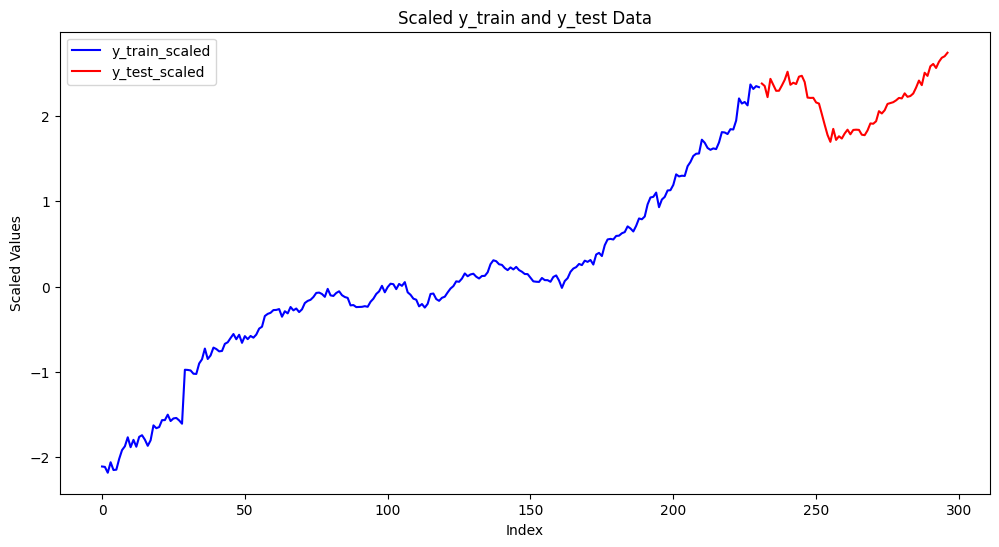

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train_scaled, label='y_train_scaled', color='blue')
plt.plot(range(len(y_train_scaled), len(y_train_scaled) + len(y_test_scaled)), y_test_scaled, label='y_test_scaled', color='red')

plt.title('Scaled y_train and y_test Data')
plt.xlabel('Index')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

### Train the model

In [5]:
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K

batch_size = 32
epochs = 650

steps_per_epoch = len(X_train_scaled) // batch_size
initial_learning_rate = 0.0008  # Learning rate inicial
teps_per_epoch = len(X_train_scaled) // batch_size
decay_steps = steps_per_epoch * 10  # O decaimento ocorre após 10 épocas
decay_rate = 0.959  # Decaimento de 5% a cada 10 épocas
activationF = 'tanh'


lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # Usar degraus para diminuir a learning rate
)

def r2_scoree(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2


model = Sequential()
model.add(LSTM(320, activation=activationF, return_sequences=True, 
               input_shape=(timesteps, features),
               kernel_regularizer=regularizers.l2(0.007)))
model.add(BatchNormalization()) 
model.add(Dropout(0.25))

model.add(LSTM(64, activation=activationF, 
               kernel_regularizer=regularizers.l2(0.0045)))
model.add(BatchNormalization()) 
# model.add(Dropout(0.3))

model.add(Dense(batch_size, activation=activationF))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=Huber(),  # Função de perda
              metrics=['mae', r2_scoree])
                #   MeanAbsoluteError(), MeanSquaredError(), RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=150, 
                               restore_best_weights=True)
# model.summary()

history = model.fit(X_train_scaled, y_train_scaled, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=[early_stopping])




Epoch 1/650


c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 2.8665 - mae: 0.9856 - r2_scoree: -0.5813

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6299 - mae: 0.7438 - r2_scoree: 0.0061 

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 2.6180 - mae: 0.7328 - r2_scoree: 0.0253 - val_loss: 3.8182 - val_mae: 2.1930 - val_r2_scoree: -6101.0327


Epoch 2/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.3515 - mae: 0.5676 - r2_scoree: 0.5626

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2762 - mae: 0.5078 - r2_scoree: 0.5796 - val_loss: 3.7670 - val_mae: 2.2917 - val_r2_scoree: -6599.3457


Epoch 3/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.0934 - mae: 0.4007 - r2_scoree: 0.7181

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0719 - mae: 0.4097 - r2_scoree: 0.7218 - val_loss: 3.6106 - val_mae: 2.2708 - val_r2_scoree: -6503.7095


Epoch 4/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9151 - mae: 0.3387 - r2_scoree: 0.8852

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8883 - mae: 0.3301 - r2_scoree: 0.8389 - val_loss: 3.4981 - val_mae: 2.2811 - val_r2_scoree: -6553.2925


Epoch 5/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7887 - mae: 0.3238 - r2_scoree: 0.7907

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7597 - mae: 0.3033 - r2_scoree: 0.8374 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7575 - mae: 0.3032 - r2_scoree: 0.8386 - val_loss: 3.4129 - val_mae: 2.3065 - val_r2_scoree: -6675.8013


Epoch 6/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.6501 - mae: 0.2547 - r2_scoree: 0.9303

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6470 - mae: 0.2842 - r2_scoree: 0.8519 - val_loss: 3.2868 - val_mae: 2.2792 - val_r2_scoree: -6584.3003


Epoch 7/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.5561 - mae: 0.2569 - r2_scoree: 0.7701

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5433 - mae: 0.2725 - r2_scoree: 0.8431 - val_loss: 3.2003 - val_mae: 2.2812 - val_r2_scoree: -6570.6655


Epoch 8/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4451 - mae: 0.1888 - r2_scoree: 0.9427

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4461 - mae: 0.2417 - r2_scoree: 0.9008 - val_loss: 3.1116 - val_mae: 2.2727 - val_r2_scoree: -6493.2656


Epoch 9/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3800 - mae: 0.2292 - r2_scoree: 0.9389

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3673 - mae: 0.2447 - r2_scoree: 0.9017 - val_loss: 3.0149 - val_mae: 2.2485 - val_r2_scoree: -6457.6187


Epoch 10/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.2860 - mae: 0.1609 - r2_scoree: 0.9470

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2794 - mae: 0.1912 - r2_scoree: 0.9303 - val_loss: 2.9405 - val_mae: 2.2390 - val_r2_scoree: -6441.7246


Epoch 11/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.2241 - mae: 0.1710 - r2_scoree: 0.9507

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2312 - mae: 0.2201 - r2_scoree: 0.9095 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2297 - mae: 0.2191 - r2_scoree: 0.9079 - val_loss: 2.9049 - val_mae: 2.2634 - val_r2_scoree: -6550.5073


Epoch 12/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1795 - mae: 0.2180 - r2_scoree: 0.8949

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1649 - mae: 0.2110 - r2_scoree: 0.8926 - val_loss: 2.8401 - val_mae: 2.2544 - val_r2_scoree: -6519.6133


Epoch 13/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1161 - mae: 0.1852 - r2_scoree: 0.9157

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1044 - mae: 0.1939 - r2_scoree: 0.9277 - val_loss: 2.7795 - val_mae: 2.2459 - val_r2_scoree: -6465.5337


Epoch 14/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0586 - mae: 0.1749 - r2_scoree: 0.9591

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0471 - mae: 0.1752 - r2_scoree: 0.9440 - val_loss: 2.7258 - val_mae: 2.2404 - val_r2_scoree: -6490.9077


Epoch 15/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.9991 - mae: 0.1264 - r2_scoree: 0.9747

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9950 - mae: 0.1559 - r2_scoree: 0.9538 - val_loss: 2.6897 - val_mae: 2.2499 - val_r2_scoree: -6526.3823


Epoch 16/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9598 - mae: 0.1631 - r2_scoree: 0.9555

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9538 - mae: 0.1696 - r2_scoree: 0.9505 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9534 - mae: 0.1709 - r2_scoree: 0.9489 - val_loss: 2.6387 - val_mae: 2.2416 - val_r2_scoree: -6504.7637


Epoch 17/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9155 - mae: 0.1575 - r2_scoree: 0.9591

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9096 - mae: 0.1643 - r2_scoree: 0.9442 - val_loss: 2.5709 - val_mae: 2.2141 - val_r2_scoree: -6354.8159


Epoch 18/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.8766 - mae: 0.1543 - r2_scoree: 0.9610

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8679 - mae: 0.1546 - r2_scoree: 0.9563 - val_loss: 2.5388 - val_mae: 2.2187 - val_r2_scoree: -6407.8267


Epoch 19/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8361 - mae: 0.1551 - r2_scoree: 0.9687

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8283 - mae: 0.1487 - r2_scoree: 0.9650 - val_loss: 2.5381 - val_mae: 2.2520 - val_r2_scoree: -6582.3345


Epoch 20/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7996 - mae: 0.1357 - r2_scoree: 0.9657

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7979 - mae: 0.1523 - r2_scoree: 0.9598 - val_loss: 2.4470 - val_mae: 2.1934 - val_r2_scoree: -6291.9648


Epoch 21/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7680 - mae: 0.1238 - r2_scoree: 0.9784

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7649 - mae: 0.1374 - r2_scoree: 0.9685 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7636 - mae: 0.1382 - r2_scoree: 0.9654 - val_loss: 2.3583 - val_mae: 2.1356 - val_r2_scoree: -6160.8457


Epoch 22/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7310 - mae: 0.1061 - r2_scoree: 0.9848

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7293 - mae: 0.1306 - r2_scoree: 0.9673 - val_loss: 2.2965 - val_mae: 2.1033 - val_r2_scoree: -6052.2573


Epoch 23/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7047 - mae: 0.1126 - r2_scoree: 0.9834

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7023 - mae: 0.1358 - r2_scoree: 0.9649 - val_loss: 2.2058 - val_mae: 2.0407 - val_r2_scoree: -5787.1660


Epoch 24/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6759 - mae: 0.1173 - r2_scoree: 0.9715

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6716 - mae: 0.1291 - r2_scoree: 0.9692 - val_loss: 2.1553 - val_mae: 2.0170 - val_r2_scoree: -5724.5786


Epoch 25/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6692 - mae: 0.1883 - r2_scoree: 0.8767

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6532 - mae: 0.1579 - r2_scoree: 0.9377 - val_loss: 2.1276 - val_mae: 2.0147 - val_r2_scoree: -5723.3599


Epoch 26/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6265 - mae: 0.1307 - r2_scoree: 0.9772

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6228 - mae: 0.1378 - r2_scoree: 0.9638 - val_loss: 2.1259 - val_mae: 2.0374 - val_r2_scoree: -5874.7866


Epoch 27/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6005 - mae: 0.1295 - r2_scoree: 0.9767

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5976 - mae: 0.1319 - r2_scoree: 0.9604 - val_loss: 2.0622 - val_mae: 1.9960 - val_r2_scoree: -5851.3628


Epoch 28/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5826 - mae: 0.1517 - r2_scoree: 0.9702

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5760 - mae: 0.1376 - r2_scoree: 0.9695 - val_loss: 1.6970 - val_mae: 1.6508 - val_r2_scoree: -4850.5010


Epoch 29/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5547 - mae: 0.1040 - r2_scoree: 0.9814

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5572 - mae: 0.1357 - r2_scoree: 0.9584 - val_loss: 1.5639 - val_mae: 1.5372 - val_r2_scoree: -4588.2993


Epoch 30/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5387 - mae: 0.1255 - r2_scoree: 0.9779

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5375 - mae: 0.1394 - r2_scoree: 0.9684 - val_loss: 1.4079 - val_mae: 1.3993 - val_r2_scoree: -4186.9907


Epoch 31/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5189 - mae: 0.1153 - r2_scoree: 0.9775

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5195 - mae: 0.1398 - r2_scoree: 0.9548 - val_loss: 1.3394 - val_mae: 1.3482 - val_r2_scoree: -4056.8438


Epoch 32/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5015 - mae: 0.1211 - r2_scoree: 0.9628

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4994 - mae: 0.1304 - r2_scoree: 0.9686 - val_loss: 1.3355 - val_mae: 1.3618 - val_r2_scoree: -4217.1885


Epoch 33/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4848 - mae: 0.1246 - r2_scoree: 0.9785

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4823 - mae: 0.1279 - r2_scoree: 0.9420 - val_loss: 1.2477 - val_mae: 1.2890 - val_r2_scoree: -3989.2371


Epoch 34/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4672 - mae: 0.1215 - r2_scoree: 0.9757

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4628 - mae: 0.1186 - r2_scoree: 0.9720 - val_loss: 1.2664 - val_mae: 1.3249 - val_r2_scoree: -4098.8003


Epoch 35/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4465 - mae: 0.0961 - r2_scoree: 0.9830

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4466 - mae: 0.1173 - r2_scoree: 0.9704 - val_loss: 1.2452 - val_mae: 1.3191 - val_r2_scoree: -4068.7434


Epoch 36/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4333 - mae: 0.1232 - r2_scoree: 0.9811

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4322 - mae: 0.1254 - r2_scoree: 0.9740 - val_loss: 1.1446 - val_mae: 1.2290 - val_r2_scoree: -3748.2117


Epoch 37/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4230 - mae: 0.1237 - r2_scoree: 0.9732

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4201 - mae: 0.1307 - r2_scoree: 0.9716 - val_loss: 1.2323 - val_mae: 1.3344 - val_r2_scoree: -4160.5352


Epoch 38/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4120 - mae: 0.1446 - r2_scoree: 0.9413

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4059 - mae: 0.1316 - r2_scoree: 0.9642 - val_loss: 1.1996 - val_mae: 1.3141 - val_r2_scoree: -4141.4478


Epoch 39/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3918 - mae: 0.1093 - r2_scoree: 0.9749

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3924 - mae: 0.1232 - r2_scoree: 0.9708 - val_loss: 1.0902 - val_mae: 1.2098 - val_r2_scoree: -3968.1042


Epoch 40/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3806 - mae: 0.1259 - r2_scoree: 0.9702

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3762 - mae: 0.1105 - r2_scoree: 0.9766 - val_loss: 0.9611 - val_mae: 1.0766 - val_r2_scoree: -3597.5837


Epoch 41/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3690 - mae: 0.1159 - r2_scoree: 0.9770

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3645 - mae: 0.1053 - r2_scoree: 0.9750 - val_loss: 0.9472 - val_mae: 1.0726 - val_r2_scoree: -3650.7686


Epoch 42/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3540 - mae: 0.1087 - r2_scoree: 0.9612

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3508 - mae: 0.1032 - r2_scoree: 0.9774 - val_loss: 0.9427 - val_mae: 1.0778 - val_r2_scoree: -3717.8311


Epoch 43/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3444 - mae: 0.1244 - r2_scoree: 0.9842

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3401 - mae: 0.1106 - r2_scoree: 0.9823 - val_loss: 0.9146 - val_mae: 1.0564 - val_r2_scoree: -3656.4329


Epoch 44/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3289 - mae: 0.0899 - r2_scoree: 0.9860

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3274 - mae: 0.0952 - r2_scoree: 0.9836 - val_loss: 0.9725 - val_mae: 1.1342 - val_r2_scoree: -3948.1680


Epoch 45/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3194 - mae: 0.1108 - r2_scoree: 0.9836

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3165 - mae: 0.0988 - r2_scoree: 0.9831 - val_loss: 0.9871 - val_mae: 1.1593 - val_r2_scoree: -4150.6353


Epoch 46/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3086 - mae: 0.0925 - r2_scoree: 0.9847

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3072 - mae: 0.0970 - r2_scoree: 0.9796 - val_loss: 0.7395 - val_mae: 0.8693 - val_r2_scoree: -3251.6897


Epoch 47/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3007 - mae: 0.1132 - r2_scoree: 0.9733

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2972 - mae: 0.0998 - r2_scoree: 0.9768 - val_loss: 0.6859 - val_mae: 0.8143 - val_r2_scoree: -3010.5830


Epoch 48/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2881 - mae: 0.0844 - r2_scoree: 0.9903

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2876 - mae: 0.0968 - r2_scoree: 0.9817 - val_loss: 0.7225 - val_mae: 0.8764 - val_r2_scoree: -3247.1748


Epoch 49/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2807 - mae: 0.0957 - r2_scoree: 0.9843

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2811 - mae: 0.1052 - r2_scoree: 0.9661 - val_loss: 0.7175 - val_mae: 0.8868 - val_r2_scoree: -3175.9163


Epoch 50/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2743 - mae: 0.1133 - r2_scoree: 0.9732

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2730 - mae: 0.1141 - r2_scoree: 0.9762 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2728 - mae: 0.1139 - r2_scoree: 0.9762 - val_loss: 0.6977 - val_mae: 0.8724 - val_r2_scoree: -3128.2295


Epoch 51/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2688 - mae: 0.1270 - r2_scoree: 0.9597

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2654 - mae: 0.1183 - r2_scoree: 0.9718 - val_loss: 0.6315 - val_mae: 0.7866 - val_r2_scoree: -2898.2576


Epoch 52/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2556 - mae: 0.1070 - r2_scoree: 0.9851

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2545 - mae: 0.1032 - r2_scoree: 0.9760 - val_loss: 0.6569 - val_mae: 0.8272 - val_r2_scoree: -3112.5576


Epoch 53/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2468 - mae: 0.0978 - r2_scoree: 0.9835

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2473 - mae: 0.1048 - r2_scoree: 0.9811 - val_loss: 0.7214 - val_mae: 0.9126 - val_r2_scoree: -3574.6731


Epoch 54/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2449 - mae: 0.1163 - r2_scoree: 0.9790

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2407 - mae: 0.1079 - r2_scoree: 0.9804 - val_loss: 0.7982 - val_mae: 1.0160 - val_r2_scoree: -3940.9460


Epoch 55/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2347 - mae: 0.0962 - r2_scoree: 0.9764

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2333 - mae: 0.0993 - r2_scoree: 0.9807 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2337 - mae: 0.1020 - r2_scoree: 0.9761 - val_loss: 0.8091 - val_mae: 1.0343 - val_r2_scoree: -4067.8582


Epoch 56/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2247 - mae: 0.0811 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2256 - mae: 0.0963 - r2_scoree: 0.9838 - val_loss: 0.7515 - val_mae: 0.9707 - val_r2_scoree: -3779.1833


Epoch 57/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2227 - mae: 0.1154 - r2_scoree: 0.9749

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2239 - mae: 0.1240 - r2_scoree: 0.9725 - val_loss: 0.6954 - val_mae: 0.9021 - val_r2_scoree: -3414.0413


Epoch 58/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2147 - mae: 0.1011 - r2_scoree: 0.9828

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2139 - mae: 0.1006 - r2_scoree: 0.9814 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2139 - mae: 0.1011 - r2_scoree: 0.9807 - val_loss: 0.7501 - val_mae: 0.9699 - val_r2_scoree: -3633.6836


Epoch 59/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2083 - mae: 0.1044 - r2_scoree: 0.9831

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2075 - mae: 0.1043 - r2_scoree: 0.9824 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2074 - mae: 0.1041 - r2_scoree: 0.9825 - val_loss: 0.6177 - val_mae: 0.7986 - val_r2_scoree: -3056.5955


Epoch 60/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1996 - mae: 0.0764 - r2_scoree: 0.9882

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1993 - mae: 0.0840 - r2_scoree: 0.9869 - val_loss: 0.5678 - val_mae: 0.7449 - val_r2_scoree: -2742.1904


Epoch 61/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1948 - mae: 0.0952 - r2_scoree: 0.9878

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1951 - mae: 0.0968 - r2_scoree: 0.9824 - val_loss: 0.5556 - val_mae: 0.7478 - val_r2_scoree: -2608.4775


Epoch 62/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1907 - mae: 0.1001 - r2_scoree: 0.9857

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1898 - mae: 0.1001 - r2_scoree: 0.9810 - val_loss: 0.5112 - val_mae: 0.6996 - val_r2_scoree: -2362.4084


Epoch 63/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1855 - mae: 0.0977 - r2_scoree: 0.9895

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1854 - mae: 0.1024 - r2_scoree: 0.9791 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1855 - mae: 0.1030 - r2_scoree: 0.9766 - val_loss: 0.5636 - val_mae: 0.7734 - val_r2_scoree: -2583.1301


Epoch 64/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1768 - mae: 0.0729 - r2_scoree: 0.9896

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1782 - mae: 0.0953 - r2_scoree: 0.9850 - val_loss: 0.7518 - val_mae: 0.9975 - val_r2_scoree: -3536.1699


Epoch 65/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1724 - mae: 0.0744 - r2_scoree: 0.9913

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1735 - mae: 0.0938 - r2_scoree: 0.9824 - val_loss: 0.8580 - val_mae: 1.1230 - val_r2_scoree: -3993.6702


Epoch 66/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1671 - mae: 0.0805 - r2_scoree: 0.9909

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1673 - mae: 0.0867 - r2_scoree: 0.9872 - val_loss: 0.9790 - val_mae: 1.2687 - val_r2_scoree: -4553.9277


Epoch 67/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1640 - mae: 0.0898 - r2_scoree: 0.9861

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1642 - mae: 0.0936 - r2_scoree: 0.9853 - val_loss: 1.0850 - val_mae: 1.3855 - val_r2_scoree: -5203.2993


Epoch 68/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1572 - mae: 0.0693 - r2_scoree: 0.9881

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1588 - mae: 0.0891 - r2_scoree: 0.9790 - val_loss: 0.9912 - val_mae: 1.2634 - val_r2_scoree: -5076.0005


Epoch 69/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1550 - mae: 0.0981 - r2_scoree: 0.9754

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1557 - mae: 0.1060 - r2_scoree: 0.9801 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1557 - mae: 0.1063 - r2_scoree: 0.9801 - val_loss: 0.9571 - val_mae: 1.2153 - val_r2_scoree: -5836.7378


Epoch 70/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1522 - mae: 0.0969 - r2_scoree: 0.9892

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1518 - mae: 0.0997 - r2_scoree: 0.9844 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1518 - mae: 0.0998 - r2_scoree: 0.9843 - val_loss: 0.7394 - val_mae: 0.9669 - val_r2_scoree: -4372.5396


Epoch 71/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1463 - mae: 0.0810 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1490 - mae: 0.0982 - r2_scoree: 0.9534 - val_loss: 0.8305 - val_mae: 1.0541 - val_r2_scoree: -4929.4341


Epoch 72/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1430 - mae: 0.0931 - r2_scoree: 0.9888

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1437 - mae: 0.0998 - r2_scoree: 0.9837 - val_loss: 1.4196 - val_mae: 1.7355 - val_r2_scoree: -7736.7637


Epoch 73/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1447 - mae: 0.1134 - r2_scoree: 0.9842

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1447 - mae: 0.1133 - r2_scoree: 0.9731 - val_loss: 1.1553 - val_mae: 1.4418 - val_r2_scoree: -6330.5957


Epoch 74/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1378 - mae: 0.0925 - r2_scoree: 0.9854

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1394 - mae: 0.1053 - r2_scoree: 0.9809 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1395 - mae: 0.1063 - r2_scoree: 0.9804 - val_loss: 0.3692 - val_mae: 0.5063 - val_r2_scoree: -1820.3584


Epoch 75/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1377 - mae: 0.1042 - r2_scoree: 0.9730

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1377 - mae: 0.1078 - r2_scoree: 0.9751 - val_loss: 0.3320 - val_mae: 0.4709 - val_r2_scoree: -1749.4038


Epoch 76/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1321 - mae: 0.0982 - r2_scoree: 0.9899

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1343 - mae: 0.1116 - r2_scoree: 0.9510 - val_loss: 0.4627 - val_mae: 0.6295 - val_r2_scoree: -2234.0769


Epoch 77/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1332 - mae: 0.1113 - r2_scoree: 0.9811

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1307 - mae: 0.1073 - r2_scoree: 0.9775 - val_loss: 0.6195 - val_mae: 0.8389 - val_r2_scoree: -3046.5312


Epoch 78/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1250 - mae: 0.0928 - r2_scoree: 0.9854

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1255 - mae: 0.0960 - r2_scoree: 0.9843 - val_loss: 0.9269 - val_mae: 1.2680 - val_r2_scoree: -4099.8247


Epoch 79/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1197 - mae: 0.0744 - r2_scoree: 0.9940

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1225 - mae: 0.0884 - r2_scoree: 0.9782 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1226 - mae: 0.0886 - r2_scoree: 0.9730 - val_loss: 1.0827 - val_mae: 1.4171 - val_r2_scoree: -4667.0000


Epoch 80/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1164 - mae: 0.0674 - r2_scoree: 0.9908

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1187 - mae: 0.0917 - r2_scoree: 0.9853 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1187 - mae: 0.0923 - r2_scoree: 0.9837 - val_loss: 1.1383 - val_mae: 1.5039 - val_r2_scoree: -4674.7036


Epoch 81/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1201 - mae: 0.1148 - r2_scoree: 0.9859

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1224 - mae: 0.1160 - r2_scoree: 0.9687 - val_loss: 0.4124 - val_mae: 0.5821 - val_r2_scoree: -2709.9927


Epoch 82/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1205 - mae: 0.1232 - r2_scoree: 0.9752

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1199 - mae: 0.1263 - r2_scoree: 0.9286 - val_loss: 0.2136 - val_mae: 0.3353 - val_r2_scoree: -1159.8612


Epoch 83/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1188 - mae: 0.1295 - r2_scoree: 0.9749

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1148 - mae: 0.1088 - r2_scoree: 0.9804 - val_loss: 0.1646 - val_mae: 0.2642 - val_r2_scoree: -595.0674


Epoch 84/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1118 - mae: 0.0956 - r2_scoree: 0.9679

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1098 - mae: 0.0898 - r2_scoree: 0.9796 - val_loss: 0.1524 - val_mae: 0.2472 - val_r2_scoree: -462.1244


Epoch 85/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1063 - mae: 0.0824 - r2_scoree: 0.9756

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1073 - mae: 0.0929 - r2_scoree: 0.9829 - val_loss: 0.1582 - val_mae: 0.2777 - val_r2_scoree: -236.2104


Epoch 86/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1065 - mae: 0.0900 - r2_scoree: 0.9858

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1042 - mae: 0.0872 - r2_scoree: 0.9860 - val_loss: 0.1505 - val_mae: 0.2641 - val_r2_scoree: -220.8902


Epoch 87/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0997 - mae: 0.0727 - r2_scoree: 0.9888

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1001 - mae: 0.0795 - r2_scoree: 0.9888 - val_loss: 0.1466 - val_mae: 0.2636 - val_r2_scoree: -282.4667


Epoch 88/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0975 - mae: 0.0713 - r2_scoree: 0.9861

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0974 - mae: 0.0799 - r2_scoree: 0.9884 - val_loss: 0.1460 - val_mae: 0.2680 - val_r2_scoree: -346.5262


Epoch 89/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0948 - mae: 0.0574 - r2_scoree: 0.9922

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0967 - mae: 0.0747 - r2_scoree: 0.9099 - val_loss: 0.1482 - val_mae: 0.2679 - val_r2_scoree: -439.4633


Epoch 90/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0936 - mae: 0.0848 - r2_scoree: 0.9868

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0928 - mae: 0.0809 - r2_scoree: 0.9882 - val_loss: 0.1851 - val_mae: 0.3138 - val_r2_scoree: -693.8753


Epoch 91/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0925 - mae: 0.0889 - r2_scoree: 0.9898

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0953 - mae: 0.1046 - r2_scoree: 0.9779 - val_loss: 0.3120 - val_mae: 0.5525 - val_r2_scoree: -1138.9260


Epoch 92/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0920 - mae: 0.0956 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0932 - mae: 0.1003 - r2_scoree: 0.9831 - val_loss: 0.4528 - val_mae: 0.7518 - val_r2_scoree: -1510.6479


Epoch 93/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0880 - mae: 0.0727 - r2_scoree: 0.9883

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0902 - mae: 0.0902 - r2_scoree: 0.9849 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0903 - mae: 0.0908 - r2_scoree: 0.9845 - val_loss: 0.4720 - val_mae: 0.7835 - val_r2_scoree: -1519.0824


Epoch 94/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0878 - mae: 0.0862 - r2_scoree: 0.9882

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0866 - mae: 0.0784 - r2_scoree: 0.9885 - val_loss: 0.5044 - val_mae: 0.8299 - val_r2_scoree: -1684.4423


Epoch 95/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0848 - mae: 0.0828 - r2_scoree: 0.9917

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0850 - mae: 0.0840 - r2_scoree: 0.9874 - val_loss: 0.5812 - val_mae: 0.9143 - val_r2_scoree: -2001.4659


Epoch 96/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0806 - mae: 0.0665 - r2_scoree: 0.9911

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0812 - mae: 0.0728 - r2_scoree: 0.9902 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0814 - mae: 0.0748 - r2_scoree: 0.9894 - val_loss: 0.6687 - val_mae: 1.0181 - val_r2_scoree: -2251.4661


Epoch 97/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0797 - mae: 0.0766 - r2_scoree: 0.9917

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0825 - mae: 0.0889 - r2_scoree: 0.9789 - val_loss: 0.5368 - val_mae: 0.8779 - val_r2_scoree: -1852.8262


Epoch 98/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0825 - mae: 0.1186 - r2_scoree: 0.9667

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0823 - mae: 0.1091 - r2_scoree: 0.9556 - val_loss: 0.6248 - val_mae: 0.9726 - val_r2_scoree: -2324.0208


Epoch 99/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0794 - mae: 0.0850 - r2_scoree: 0.9840

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0801 - mae: 0.0964 - r2_scoree: 0.9815 - val_loss: 0.6242 - val_mae: 0.9473 - val_r2_scoree: -2776.2539


Epoch 100/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0781 - mae: 0.0883 - r2_scoree: 0.9832

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0784 - mae: 0.0974 - r2_scoree: 0.9768 - val_loss: 0.4422 - val_mae: 0.6764 - val_r2_scoree: -2465.3542


Epoch 101/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0740 - mae: 0.0854 - r2_scoree: 0.9864

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0773 - mae: 0.1012 - r2_scoree: 0.9638 - val_loss: 0.1628 - val_mae: 0.3449 - val_r2_scoree: -611.0400


Epoch 102/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0731 - mae: 0.0910 - r2_scoree: 0.9847

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0763 - mae: 0.1014 - r2_scoree: 0.9658 - val_loss: 0.1369 - val_mae: 0.2954 - val_r2_scoree: -682.6909


Epoch 103/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0733 - mae: 0.0952 - r2_scoree: 0.9822

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0740 - mae: 0.0979 - r2_scoree: 0.9815 - val_loss: 0.1184 - val_mae: 0.2540 - val_r2_scoree: -379.1729


Epoch 104/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0751 - mae: 0.1072 - r2_scoree: 0.9771

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0744 - mae: 0.0976 - r2_scoree: 0.9810 - val_loss: 0.1332 - val_mae: 0.2796 - val_r2_scoree: -694.7447


Epoch 105/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0739 - mae: 0.0871 - r2_scoree: 0.9803

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0745 - mae: 0.0979 - r2_scoree: 0.8942 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0748 - mae: 0.0993 - r2_scoree: 0.8256 - val_loss: 0.1296 - val_mae: 0.2799 - val_r2_scoree: -652.8128


Epoch 106/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0704 - mae: 0.0859 - r2_scoree: 0.9874

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0754 - mae: 0.1137 - r2_scoree: 0.9746 - val_loss: 0.1288 - val_mae: 0.2755 - val_r2_scoree: -591.0428


Epoch 107/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0692 - mae: 0.0841 - r2_scoree: 0.9907

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0729 - mae: 0.1050 - r2_scoree: 0.9773 - val_loss: 0.3153 - val_mae: 0.6415 - val_r2_scoree: -1240.8043


Epoch 108/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0723 - mae: 0.1056 - r2_scoree: 0.9848

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0696 - mae: 0.0900 - r2_scoree: 0.9859 - val_loss: 0.3145 - val_mae: 0.6337 - val_r2_scoree: -1330.3252


Epoch 109/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0671 - mae: 0.0845 - r2_scoree: 0.9888

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0687 - mae: 0.0943 - r2_scoree: 0.9820 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0688 - mae: 0.0948 - r2_scoree: 0.9819 - val_loss: 0.2119 - val_mae: 0.4404 - val_r2_scoree: -1018.4832


Epoch 110/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0681 - mae: 0.0951 - r2_scoree: 0.9835

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0674 - mae: 0.0937 - r2_scoree: 0.9838 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0674 - mae: 0.0948 - r2_scoree: 0.9822 - val_loss: 0.1246 - val_mae: 0.2621 - val_r2_scoree: -619.7639


Epoch 111/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0616 - mae: 0.0552 - r2_scoree: 0.9948

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0642 - mae: 0.0801 - r2_scoree: 0.9852 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0644 - mae: 0.0812 - r2_scoree: 0.9827 - val_loss: 0.1125 - val_mae: 0.2473 - val_r2_scoree: -540.7889


Epoch 112/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0633 - mae: 0.0880 - r2_scoree: 0.9748

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0625 - mae: 0.0850 - r2_scoree: 0.9844 - val_loss: 0.1159 - val_mae: 0.2567 - val_r2_scoree: -595.5648


Epoch 113/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0604 - mae: 0.0801 - r2_scoree: 0.9918

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0622 - mae: 0.0942 - r2_scoree: 0.9852 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0623 - mae: 0.0944 - r2_scoree: 0.9850 - val_loss: 0.1030 - val_mae: 0.2338 - val_r2_scoree: -490.1097


Epoch 114/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0607 - mae: 0.0922 - r2_scoree: 0.9814

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0607 - mae: 0.0899 - r2_scoree: 0.9812 - val_loss: 0.1136 - val_mae: 0.2522 - val_r2_scoree: -617.6255


Epoch 115/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0575 - mae: 0.0738 - r2_scoree: 0.9914

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0620 - mae: 0.0940 - r2_scoree: 0.9785 - val_loss: 0.7064 - val_mae: 1.1265 - val_r2_scoree: -2520.8586


Epoch 116/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0554 - mae: 0.0655 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0577 - mae: 0.0832 - r2_scoree: 0.9857 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0579 - mae: 0.0846 - r2_scoree: 0.9839 - val_loss: 0.5126 - val_mae: 0.9131 - val_r2_scoree: -2217.1711


Epoch 117/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0573 - mae: 0.0882 - r2_scoree: 0.9856

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0572 - mae: 0.0851 - r2_scoree: 0.9850 - val_loss: 0.1483 - val_mae: 0.3151 - val_r2_scoree: -993.2153


Epoch 118/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0591 - mae: 0.1067 - r2_scoree: 0.9834

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0585 - mae: 0.0946 - r2_scoree: 0.9828 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0584 - mae: 0.0941 - r2_scoree: 0.9824 - val_loss: 0.1410 - val_mae: 0.3082 - val_r2_scoree: -995.9880


Epoch 119/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0569 - mae: 0.0925 - r2_scoree: 0.9841

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0561 - mae: 0.0895 - r2_scoree: 0.9804 - val_loss: 0.2145 - val_mae: 0.4834 - val_r2_scoree: -1272.0491


Epoch 120/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0533 - mae: 0.0772 - r2_scoree: 0.9825

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0535 - mae: 0.0803 - r2_scoree: 0.9865 - val_loss: 0.1542 - val_mae: 0.3552 - val_r2_scoree: -978.6950


Epoch 121/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0516 - mae: 0.0748 - r2_scoree: 0.9903

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0523 - mae: 0.0805 - r2_scoree: 0.9750 - val_loss: 0.1069 - val_mae: 0.2651 - val_r2_scoree: -678.9402


Epoch 122/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0509 - mae: 0.0805 - r2_scoree: 0.9873

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0516 - mae: 0.0856 - r2_scoree: 0.9877 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0517 - mae: 0.0858 - r2_scoree: 0.9871 - val_loss: 0.1335 - val_mae: 0.3190 - val_r2_scoree: -879.5625


Epoch 123/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0497 - mae: 0.0851 - r2_scoree: 0.9901

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0495 - mae: 0.0804 - r2_scoree: 0.9868 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0496 - mae: 0.0807 - r2_scoree: 0.9840 - val_loss: 0.1281 - val_mae: 0.3011 - val_r2_scoree: -877.8904


Epoch 124/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0474 - mae: 0.0631 - r2_scoree: 0.9942

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0480 - mae: 0.0730 - r2_scoree: 0.9908 - val_loss: 0.1087 - val_mae: 0.2636 - val_r2_scoree: -760.2402


Epoch 125/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0480 - mae: 0.0853 - r2_scoree: 0.9927

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0477 - mae: 0.0806 - r2_scoree: 0.9904 - val_loss: 0.1857 - val_mae: 0.4024 - val_r2_scoree: -1269.6388


Epoch 126/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0470 - mae: 0.0795 - r2_scoree: 0.9882

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0479 - mae: 0.0764 - r2_scoree: 0.9734 - val_loss: 0.0878 - val_mae: 0.2398 - val_r2_scoree: -273.8051


Epoch 127/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0484 - mae: 0.0959 - r2_scoree: 0.9869

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0473 - mae: 0.0835 - r2_scoree: 0.9792 - val_loss: 0.1018 - val_mae: 0.2871 - val_r2_scoree: -514.1374


Epoch 128/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0523 - mae: 0.1122 - r2_scoree: 0.9802

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0503 - mae: 0.0971 - r2_scoree: 0.9834 - val_loss: 0.0974 - val_mae: 0.2713 - val_r2_scoree: -469.5439


Epoch 129/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0545 - mae: 0.0874 - r2_scoree: 0.9722

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0507 - mae: 0.0904 - r2_scoree: 0.9799 - val_loss: 0.1153 - val_mae: 0.3195 - val_r2_scoree: -584.9631


Epoch 130/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0514 - mae: 0.1047 - r2_scoree: 0.9766

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0486 - mae: 0.0896 - r2_scoree: 0.9832 - val_loss: 0.0984 - val_mae: 0.2672 - val_r2_scoree: -135.5558


Epoch 131/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0465 - mae: 0.0891 - r2_scoree: 0.9882

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0463 - mae: 0.0855 - r2_scoree: 0.9883 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0465 - mae: 0.0858 - r2_scoree: 0.9872 - val_loss: 0.0853 - val_mae: 0.2498 - val_r2_scoree: -219.8611


Epoch 132/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0488 - mae: 0.0983 - r2_scoree: 0.9737

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0465 - mae: 0.0849 - r2_scoree: 0.9766 - val_loss: 0.0893 - val_mae: 0.2522 - val_r2_scoree: -187.6502


Epoch 133/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0474 - mae: 0.0864 - r2_scoree: 0.9827

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0455 - mae: 0.0827 - r2_scoree: 0.9861 - val_loss: 0.1040 - val_mae: 0.2878 - val_r2_scoree: -96.7633


Epoch 134/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0497 - mae: 0.1110 - r2_scoree: 0.9730

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0457 - mae: 0.0925 - r2_scoree: 0.9831 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0456 - mae: 0.0927 - r2_scoree: 0.9731 - val_loss: 0.1082 - val_mae: 0.3020 - val_r2_scoree: -77.5689


Epoch 135/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0429 - mae: 0.0890 - r2_scoree: 0.9838

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0451 - mae: 0.0980 - r2_scoree: 0.9834 - val_loss: 0.1337 - val_mae: 0.3729 - val_r2_scoree: -38.7847


Epoch 136/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0439 - mae: 0.0928 - r2_scoree: 0.9880

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0420 - mae: 0.0824 - r2_scoree: 0.9876 - val_loss: 0.1015 - val_mae: 0.2935 - val_r2_scoree: -79.1689


Epoch 137/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0423 - mae: 0.0705 - r2_scoree: 0.9890

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0421 - mae: 0.0807 - r2_scoree: 0.9866 - val_loss: 0.0857 - val_mae: 0.2568 - val_r2_scoree: -126.6804


Epoch 138/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0409 - mae: 0.0863 - r2_scoree: 0.9799

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0422 - mae: 0.0919 - r2_scoree: 0.9809 - val_loss: 0.1141 - val_mae: 0.3368 - val_r2_scoree: -70.7995


Epoch 139/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0393 - mae: 0.0813 - r2_scoree: 0.9914

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0428 - mae: 0.0994 - r2_scoree: 0.9807 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0429 - mae: 0.1000 - r2_scoree: 0.9789 - val_loss: 0.0973 - val_mae: 0.2990 - val_r2_scoree: -509.0963


Epoch 140/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0389 - mae: 0.0817 - r2_scoree: 0.9849

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0426 - mae: 0.1005 - r2_scoree: 0.9728 - val_loss: 0.0723 - val_mae: 0.2297 - val_r2_scoree: -124.9004


Epoch 141/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0423 - mae: 0.1073 - r2_scoree: 0.9819

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0425 - mae: 0.1089 - r2_scoree: 0.9794 - val_loss: 0.0618 - val_mae: 0.2086 - val_r2_scoree: -165.8225


Epoch 142/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0369 - mae: 0.0719 - r2_scoree: 0.9916

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0384 - mae: 0.0822 - r2_scoree: 0.9862 - val_loss: 0.0622 - val_mae: 0.2096 - val_r2_scoree: -153.1916


Epoch 143/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0457 - mae: 0.1276 - r2_scoree: 0.9671

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0410 - mae: 0.1021 - r2_scoree: 0.9798 - val_loss: 0.0714 - val_mae: 0.2352 - val_r2_scoree: -136.9464


Epoch 144/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0389 - mae: 0.0945 - r2_scoree: 0.9893

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0399 - mae: 0.0931 - r2_scoree: 0.9686 - val_loss: 0.0870 - val_mae: 0.2674 - val_r2_scoree: -61.9234


Epoch 145/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0357 - mae: 0.0811 - r2_scoree: 0.9900

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0359 - mae: 0.0760 - r2_scoree: 0.9868 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0360 - mae: 0.0764 - r2_scoree: 0.9853 - val_loss: 0.0715 - val_mae: 0.2267 - val_r2_scoree: -64.6582


Epoch 146/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0367 - mae: 0.0816 - r2_scoree: 0.9877

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0378 - mae: 0.0930 - r2_scoree: 0.9844 - val_loss: 0.0885 - val_mae: 0.2716 - val_r2_scoree: -38.9970


Epoch 147/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0427 - mae: 0.1078 - r2_scoree: 0.9548

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0418 - mae: 0.1050 - r2_scoree: 0.9693 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0419 - mae: 0.1059 - r2_scoree: 0.9698 - val_loss: 0.0772 - val_mae: 0.2441 - val_r2_scoree: -104.6501


Epoch 148/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0356 - mae: 0.0728 - r2_scoree: 0.9906

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0376 - mae: 0.0857 - r2_scoree: 0.9848 - val_loss: 0.0763 - val_mae: 0.2501 - val_r2_scoree: -132.3007


Epoch 149/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0364 - mae: 0.0897 - r2_scoree: 0.9803

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0369 - mae: 0.0903 - r2_scoree: 0.9768 - val_loss: 0.0683 - val_mae: 0.2281 - val_r2_scoree: -179.9288


Epoch 150/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0369 - mae: 0.0971 - r2_scoree: 0.9863

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0375 - mae: 0.0926 - r2_scoree: 0.9834 - val_loss: 0.0594 - val_mae: 0.1927 - val_r2_scoree: -242.8165


Epoch 151/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0390 - mae: 0.1034 - r2_scoree: 0.9650

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0380 - mae: 0.0981 - r2_scoree: 0.9746 - val_loss: 0.0599 - val_mae: 0.1942 - val_r2_scoree: -246.6768


Epoch 152/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0369 - mae: 0.0949 - r2_scoree: 0.9807

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0378 - mae: 0.0992 - r2_scoree: 0.9787 - val_loss: 0.0591 - val_mae: 0.1948 - val_r2_scoree: -215.9842


Epoch 153/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0448 - mae: 0.1343 - r2_scoree: 0.9742

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0386 - mae: 0.1031 - r2_scoree: 0.9813 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0382 - mae: 0.1014 - r2_scoree: 0.9813 - val_loss: 0.0593 - val_mae: 0.1988 - val_r2_scoree: -189.8302


Epoch 154/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0373 - mae: 0.1002 - r2_scoree: 0.9830

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0357 - mae: 0.0925 - r2_scoree: 0.9851 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0358 - mae: 0.0931 - r2_scoree: 0.9845 - val_loss: 0.0583 - val_mae: 0.1929 - val_r2_scoree: -261.6220


Epoch 155/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0318 - mae: 0.0683 - r2_scoree: 0.9942

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0327 - mae: 0.0753 - r2_scoree: 0.9894 - val_loss: 0.0593 - val_mae: 0.2005 - val_r2_scoree: -301.5591


Epoch 156/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0352 - mae: 0.0980 - r2_scoree: 0.9796

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0331 - mae: 0.0832 - r2_scoree: 0.9866 - val_loss: 0.0615 - val_mae: 0.2124 - val_r2_scoree: -331.3726


Epoch 157/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0303 - mae: 0.0679 - r2_scoree: 0.9924

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0314 - mae: 0.0737 - r2_scoree: 0.9899 - val_loss: 0.0601 - val_mae: 0.2118 - val_r2_scoree: -311.2686


Epoch 158/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0293 - mae: 0.0637 - r2_scoree: 0.9939

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0305 - mae: 0.0690 - r2_scoree: 0.9879 - val_loss: 0.0633 - val_mae: 0.2264 - val_r2_scoree: -334.7469


Epoch 159/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0300 - mae: 0.0759 - r2_scoree: 0.9928

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0308 - mae: 0.0766 - r2_scoree: 0.9899 - val_loss: 0.1146 - val_mae: 0.3462 - val_r2_scoree: -654.2290


Epoch 160/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0358 - mae: 0.1190 - r2_scoree: 0.9800

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0345 - mae: 0.1049 - r2_scoree: 0.9752 - val_loss: 0.1143 - val_mae: 0.3491 - val_r2_scoree: -635.1922


Epoch 161/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0332 - mae: 0.0994 - r2_scoree: 0.9844

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0330 - mae: 0.0977 - r2_scoree: 0.9816 - val_loss: 0.0784 - val_mae: 0.2784 - val_r2_scoree: -366.1380


Epoch 162/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0297 - mae: 0.0744 - r2_scoree: 0.9902

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0307 - mae: 0.0809 - r2_scoree: 0.9876 - val_loss: 0.0862 - val_mae: 0.2895 - val_r2_scoree: -114.9467


Epoch 163/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0323 - mae: 0.0919 - r2_scoree: 0.9829

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0304 - mae: 0.0831 - r2_scoree: 0.9721 - val_loss: 0.0752 - val_mae: 0.2664 - val_r2_scoree: -126.9758


Epoch 164/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0291 - mae: 0.0840 - r2_scoree: 0.9846

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0314 - mae: 0.0893 - r2_scoree: 0.9842 - val_loss: 0.0784 - val_mae: 0.2637 - val_r2_scoree: -117.8960


Epoch 165/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0295 - mae: 0.0894 - r2_scoree: 0.9870

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0304 - mae: 0.0915 - r2_scoree: 0.9835 - val_loss: 0.0786 - val_mae: 0.2603 - val_r2_scoree: -113.6060


Epoch 166/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0297 - mae: 0.0880 - r2_scoree: 0.9892

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0277 - mae: 0.0751 - r2_scoree: 0.9830 - val_loss: 0.0740 - val_mae: 0.2530 - val_r2_scoree: -117.9266


Epoch 167/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0281 - mae: 0.0895 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0284 - mae: 0.0826 - r2_scoree: 0.9861 - val_loss: 0.1093 - val_mae: 0.3474 - val_r2_scoree: -22.0350


Epoch 168/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0320 - mae: 0.1066 - r2_scoree: 0.9813

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0306 - mae: 0.0986 - r2_scoree: 0.9813

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0307 - mae: 0.0987 - r2_scoree: 0.9803 - val_loss: 0.1106 - val_mae: 0.3446 - val_r2_scoree: -12.8462


Epoch 169/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0382 - mae: 0.1505 - r2_scoree: 0.9754

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0318 - mae: 0.1032 - r2_scoree: 0.9745 - val_loss: 0.0860 - val_mae: 0.2823 - val_r2_scoree: -34.3176


Epoch 170/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0260 - mae: 0.0809 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0279 - mae: 0.0855 - r2_scoree: 0.9853 - val_loss: 0.0690 - val_mae: 0.2388 - val_r2_scoree: -68.4885


Epoch 171/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0279 - mae: 0.0842 - r2_scoree: 0.9845

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0304 - mae: 0.0957 - r2_scoree: 0.9776 - val_loss: 0.0670 - val_mae: 0.2463 - val_r2_scoree: -108.2595


Epoch 172/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0278 - mae: 0.0878 - r2_scoree: 0.9909

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0294 - mae: 0.0992 - r2_scoree: 0.9727 - val_loss: 0.0881 - val_mae: 0.3000 - val_r2_scoree: -287.5279


Epoch 173/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0254 - mae: 0.0745 - r2_scoree: 0.9859

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0267 - mae: 0.0805 - r2_scoree: 0.9746 - val_loss: 0.0887 - val_mae: 0.3176 - val_r2_scoree: -217.6158


Epoch 174/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0258 - mae: 0.0764 - r2_scoree: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0272 - mae: 0.0912 - r2_scoree: 0.9846 - val_loss: 0.1361 - val_mae: 0.4161 - val_r2_scoree: -9.1272


Epoch 175/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0248 - mae: 0.0739 - r2_scoree: 0.9900

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0293 - mae: 0.1071 - r2_scoree: 0.9808 - val_loss: 0.0965 - val_mae: 0.3310 - val_r2_scoree: -29.2120


Epoch 176/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0255 - mae: 0.0855 - r2_scoree: 0.9875

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0271 - mae: 0.0908 - r2_scoree: 0.9778 - val_loss: 0.0568 - val_mae: 0.2183 - val_r2_scoree: -116.5924


Epoch 177/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0243 - mae: 0.0735 - r2_scoree: 0.9896

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0243 - mae: 0.0698 - r2_scoree: 0.9913 - val_loss: 0.0891 - val_mae: 0.3159 - val_r2_scoree: -406.7759


Epoch 178/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0245 - mae: 0.0749 - r2_scoree: 0.9901

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0250 - mae: 0.0790 - r2_scoree: 0.9884 - val_loss: 0.0626 - val_mae: 0.2411 - val_r2_scoree: -194.9518


Epoch 179/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0269 - mae: 0.0952 - r2_scoree: 0.9887

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265 - mae: 0.0888 - r2_scoree: 0.9862 - val_loss: 0.0879 - val_mae: 0.3167 - val_r2_scoree: -74.9295


Epoch 180/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0246 - mae: 0.0791 - r2_scoree: 0.9914

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0298 - mae: 0.1074 - r2_scoree: 0.9782 - val_loss: 0.0642 - val_mae: 0.2380 - val_r2_scoree: -142.4202


Epoch 181/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0252 - mae: 0.0885 - r2_scoree: 0.9837

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0265 - mae: 0.0908 - r2_scoree: 0.9687 - val_loss: 0.0613 - val_mae: 0.2308 - val_r2_scoree: -179.0181


Epoch 182/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0279 - mae: 0.0965 - r2_scoree: 0.9856

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0251 - mae: 0.0817 - r2_scoree: 0.9881 - val_loss: 0.1524 - val_mae: 0.4081 - val_r2_scoree: -839.8538


Epoch 183/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0252 - mae: 0.0933 - r2_scoree: 0.9899

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0280 - mae: 0.1007 - r2_scoree: 0.9822 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0282 - mae: 0.1015 - r2_scoree: 0.9802 - val_loss: 0.1033 - val_mae: 0.3559 - val_r2_scoree: -61.4099


Epoch 184/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0257 - mae: 0.0873 - r2_scoree: 0.9832

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0281 - mae: 0.0998 - r2_scoree: 0.9803 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0282 - mae: 0.1000 - r2_scoree: 0.9787 - val_loss: 0.0633 - val_mae: 0.2575 - val_r2_scoree: -272.8326


Epoch 185/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0243 - mae: 0.0788 - r2_scoree: 0.9842

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0268 - mae: 0.0926 - r2_scoree: 0.9816 - val_loss: 0.0650 - val_mae: 0.2542 - val_r2_scoree: -131.8900


Epoch 186/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0272 - mae: 0.0979 - r2_scoree: 0.9770

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0286 - mae: 0.1090 - r2_scoree: 0.9791 - val_loss: 0.1195 - val_mae: 0.3727 - val_r2_scoree: -43.8910


Epoch 187/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0271 - mae: 0.0983 - r2_scoree: 0.9820

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297 - mae: 0.1109 - r2_scoree: 0.9734 - val_loss: 0.1413 - val_mae: 0.4032 - val_r2_scoree: -11.4367


Epoch 188/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0231 - mae: 0.0757 - r2_scoree: 0.9895

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0241 - mae: 0.0839 - r2_scoree: 0.9873 - val_loss: 0.2421 - val_mae: 0.5972 - val_r2_scoree: -7.7987


Epoch 189/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0236 - mae: 0.0836 - r2_scoree: 0.9826

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0230 - mae: 0.0744 - r2_scoree: 0.9875 - val_loss: 0.2007 - val_mae: 0.5219 - val_r2_scoree: -3.1938


Epoch 190/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0220 - mae: 0.0688 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0232 - mae: 0.0763 - r2_scoree: 0.9828 - val_loss: 0.1510 - val_mae: 0.4244 - val_r2_scoree: -4.9718


Epoch 191/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0205 - mae: 0.0560 - r2_scoree: 0.9954

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0228 - mae: 0.0715 - r2_scoree: 0.9895 - val_loss: 0.1371 - val_mae: 0.3984 - val_r2_scoree: -9.6499


Epoch 192/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0209 - mae: 0.0580 - r2_scoree: 0.9942

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0224 - mae: 0.0708 - r2_scoree: 0.9904 - val_loss: 0.1510 - val_mae: 0.4341 - val_r2_scoree: -11.3882


Epoch 193/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0206 - mae: 0.0582 - r2_scoree: 0.9944

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0226 - mae: 0.0747 - r2_scoree: 0.9867 - val_loss: 0.1694 - val_mae: 0.4751 - val_r2_scoree: -10.2921


Epoch 194/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0232 - mae: 0.0909 - r2_scoree: 0.9848

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0218 - mae: 0.0741 - r2_scoree: 0.9904 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mae: 0.0740 - r2_scoree: 0.9905 - val_loss: 0.1537 - val_mae: 0.4486 - val_r2_scoree: -17.6817


Epoch 195/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0226 - mae: 0.0762 - r2_scoree: 0.9839

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - mae: 0.0726 - r2_scoree: 0.9882 - val_loss: 0.1434 - val_mae: 0.4346 - val_r2_scoree: -25.1685


Epoch 196/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0213 - mae: 0.0700 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0229 - mae: 0.0785 - r2_scoree: 0.9840 - val_loss: 0.1118 - val_mae: 0.3469 - val_r2_scoree: -26.0383


Epoch 197/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0207 - mae: 0.0721 - r2_scoree: 0.9954

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - mae: 0.0681 - r2_scoree: 0.9914 - val_loss: 0.0990 - val_mae: 0.3215 - val_r2_scoree: -34.9405


Epoch 198/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0200 - mae: 0.0649 - r2_scoree: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236 - mae: 0.0847 - r2_scoree: 0.9843 - val_loss: 0.1064 - val_mae: 0.3375 - val_r2_scoree: -28.6276


Epoch 199/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0201 - mae: 0.0716 - r2_scoree: 0.9906

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0205 - mae: 0.0729 - r2_scoree: 0.9913 - val_loss: 0.1273 - val_mae: 0.3859 - val_r2_scoree: -15.3610


Epoch 200/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0198 - mae: 0.0655 - r2_scoree: 0.9938

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202 - mae: 0.0691 - r2_scoree: 0.9887 - val_loss: 0.1703 - val_mae: 0.4836 - val_r2_scoree: -3.8324


Epoch 201/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0220 - mae: 0.0846 - r2_scoree: 0.9887

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 - mae: 0.0798 - r2_scoree: 0.9636 - val_loss: 0.1860 - val_mae: 0.4938 - val_r2_scoree: -6.3897


Epoch 202/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0192 - mae: 0.0705 - r2_scoree: 0.9906

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0206 - mae: 0.0769 - r2_scoree: 0.9876 - val_loss: 0.1988 - val_mae: 0.5362 - val_r2_scoree: -4.9326


Epoch 203/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0191 - mae: 0.0663 - r2_scoree: 0.9933

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199 - mae: 0.0690 - r2_scoree: 0.9887 - val_loss: 0.1758 - val_mae: 0.4846 - val_r2_scoree: -3.2954


Epoch 204/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0211 - mae: 0.0789 - r2_scoree: 0.9893

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0197 - mae: 0.0720 - r2_scoree: 0.9913 - val_loss: 0.1573 - val_mae: 0.4572 - val_r2_scoree: -2.2639


Epoch 205/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0191 - mae: 0.0684 - r2_scoree: 0.9907

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - mae: 0.0668 - r2_scoree: 0.9914 - val_loss: 0.1198 - val_mae: 0.3753 - val_r2_scoree: -5.9879


Epoch 206/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0175 - mae: 0.0580 - r2_scoree: 0.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - mae: 0.0700 - r2_scoree: 0.9914 - val_loss: 0.0988 - val_mae: 0.3240 - val_r2_scoree: -19.3546


Epoch 207/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0181 - mae: 0.0659 - r2_scoree: 0.9886

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - mae: 0.0714 - r2_scoree: 0.9816 - val_loss: 0.1039 - val_mae: 0.3352 - val_r2_scoree: -12.5945


Epoch 208/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0177 - mae: 0.0574 - r2_scoree: 0.9926

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - mae: 0.0718 - r2_scoree: 0.9904 - val_loss: 0.4327 - val_mae: 0.8895 - val_r2_scoree: -1703.3163


Epoch 209/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0245 - mae: 0.0849 - r2_scoree: 0.9763

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0221 - mae: 0.0870 - r2_scoree: 0.9821 - val_loss: 0.1511 - val_mae: 0.4422 - val_r2_scoree: -20.5621


Epoch 210/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0197 - mae: 0.0814 - r2_scoree: 0.9922

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - mae: 0.0772 - r2_scoree: 0.9891 - val_loss: 0.1585 - val_mae: 0.4384 - val_r2_scoree: -18.8624


Epoch 211/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0169 - mae: 0.0563 - r2_scoree: 0.9949

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - mae: 0.0710 - r2_scoree: 0.9905 - val_loss: 0.3049 - val_mae: 0.6929 - val_r2_scoree: -18.4339


Epoch 212/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0199 - mae: 0.0788 - r2_scoree: 0.9894

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 - mae: 0.0757 - r2_scoree: 0.9851 - val_loss: 0.2893 - val_mae: 0.6685 - val_r2_scoree: -15.8690


Epoch 213/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0163 - mae: 0.0562 - r2_scoree: 0.9944

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0189 - mae: 0.0701 - r2_scoree: 0.9901 - val_loss: 0.2463 - val_mae: 0.5984 - val_r2_scoree: -8.1794


Epoch 214/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0200 - mae: 0.0863 - r2_scoree: 0.9831

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195 - mae: 0.0820 - r2_scoree: 0.9868 - val_loss: 0.1788 - val_mae: 0.4816 - val_r2_scoree: -4.9466


Epoch 215/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0188 - mae: 0.0798 - r2_scoree: 0.9887

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - mae: 0.0779 - r2_scoree: 0.9892 - val_loss: 0.1523 - val_mae: 0.4397 - val_r2_scoree: -15.4630


Epoch 216/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0178 - mae: 0.0734 - r2_scoree: 0.9923

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - mae: 0.0726 - r2_scoree: 0.9909 - val_loss: 0.1358 - val_mae: 0.4085 - val_r2_scoree: -13.5606


Epoch 217/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0163 - mae: 0.0643 - r2_scoree: 0.9924

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - mae: 0.0611 - r2_scoree: 0.9932 - val_loss: 0.2106 - val_mae: 0.5527 - val_r2_scoree: -5.9683


Epoch 218/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0175 - mae: 0.0699 - r2_scoree: 0.9919

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0168 - mae: 0.0650 - r2_scoree: 0.9908 - val_loss: 0.2238 - val_mae: 0.5779 - val_r2_scoree: -9.9620


Epoch 219/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0162 - mae: 0.0604 - r2_scoree: 0.9903

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - mae: 0.0681 - r2_scoree: 0.9911 - val_loss: 0.3390 - val_mae: 0.7613 - val_r2_scoree: -94.5713


Epoch 220/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0164 - mae: 0.0637 - r2_scoree: 0.9913

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0168 - mae: 0.0665 - r2_scoree: 0.9904 - val_loss: 0.4200 - val_mae: 0.8504 - val_r2_scoree: -141.2202


Epoch 221/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0234 - mae: 0.1080 - r2_scoree: 0.9837

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - mae: 0.0830 - r2_scoree: 0.9876 - val_loss: 0.3284 - val_mae: 0.7216 - val_r2_scoree: -49.4875


Epoch 222/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0150 - mae: 0.0589 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0173 - mae: 0.0771 - r2_scoree: 0.9896 - val_loss: 0.1144 - val_mae: 0.3649 - val_r2_scoree: -33.7969


Epoch 223/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0159 - mae: 0.0700 - r2_scoree: 0.9929

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - mae: 0.0670 - r2_scoree: 0.9928 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157 - mae: 0.0669 - r2_scoree: 0.9923 - val_loss: 0.1690 - val_mae: 0.4836 - val_r2_scoree: -4.6406


Epoch 224/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0139 - mae: 0.0509 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - mae: 0.0636 - r2_scoree: 0.9911 - val_loss: 0.1435 - val_mae: 0.4322 - val_r2_scoree: -10.6705


Epoch 225/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0150 - mae: 0.0670 - r2_scoree: 0.9907

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - mae: 0.0756 - r2_scoree: 0.9895 - val_loss: 0.1331 - val_mae: 0.4095 - val_r2_scoree: -18.8031


Epoch 226/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0163 - mae: 0.0805 - r2_scoree: 0.9865

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - mae: 0.0673 - r2_scoree: 0.9910 - val_loss: 0.2576 - val_mae: 0.6330 - val_r2_scoree: -10.4384


Epoch 227/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0163 - mae: 0.0749 - r2_scoree: 0.9862

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - mae: 0.0732 - r2_scoree: 0.9854 - val_loss: 0.2730 - val_mae: 0.6452 - val_r2_scoree: -21.5716


Epoch 228/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0145 - mae: 0.0615 - r2_scoree: 0.9936

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151 - mae: 0.0641 - r2_scoree: 0.9914 - val_loss: 0.2442 - val_mae: 0.5984 - val_r2_scoree: -10.3451


Epoch 229/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0145 - mae: 0.0596 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - mae: 0.0688 - r2_scoree: 0.9919 - val_loss: 0.2138 - val_mae: 0.5527 - val_r2_scoree: -4.0020


Epoch 230/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0152 - mae: 0.0673 - r2_scoree: 0.9928

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - mae: 0.0759 - r2_scoree: 0.9904 - val_loss: 0.1732 - val_mae: 0.4772 - val_r2_scoree: -3.5974


Epoch 231/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0132 - mae: 0.0477 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - mae: 0.0612 - r2_scoree: 0.9910 - val_loss: 0.1467 - val_mae: 0.4244 - val_r2_scoree: -9.9900


Epoch 232/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0144 - mae: 0.0674 - r2_scoree: 0.9944

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - mae: 0.0777 - r2_scoree: 0.9900 - val_loss: 0.1343 - val_mae: 0.4028 - val_r2_scoree: -10.0213


Epoch 233/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0183 - mae: 0.0896 - r2_scoree: 0.9808

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0196 - mae: 0.0888 - r2_scoree: 0.9795 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0200 - mae: 0.0899 - r2_scoree: 0.9784 - val_loss: 0.0863 - val_mae: 0.3123 - val_r2_scoree: -51.5040


Epoch 234/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0169 - mae: 0.0794 - r2_scoree: 0.9883

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0203 - mae: 0.1004 - r2_scoree: 0.9773 - val_loss: 0.0944 - val_mae: 0.3442 - val_r2_scoree: -81.0488


Epoch 235/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0193 - mae: 0.0871 - r2_scoree: 0.9626

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220 - mae: 0.1083 - r2_scoree: 0.9727 - val_loss: 0.1270 - val_mae: 0.4115 - val_r2_scoree: -50.2439


Epoch 236/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0137 - mae: 0.0592 - r2_scoree: 0.9951

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - mae: 0.0689 - r2_scoree: 0.9913 - val_loss: 0.0699 - val_mae: 0.2771 - val_r2_scoree: -105.5234


Epoch 237/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0135 - mae: 0.0574 - r2_scoree: 0.9943

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - mae: 0.0736 - r2_scoree: 0.9888 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - mae: 0.0753 - r2_scoree: 0.9871 - val_loss: 0.0534 - val_mae: 0.2354 - val_r2_scoree: -159.4631


Epoch 238/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0143 - mae: 0.0646 - r2_scoree: 0.9915

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152 - mae: 0.0707 - r2_scoree: 0.9911 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - mae: 0.0719 - r2_scoree: 0.9908 - val_loss: 0.0520 - val_mae: 0.2306 - val_r2_scoree: -163.7858


Epoch 239/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0156 - mae: 0.0793 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - mae: 0.0759 - r2_scoree: 0.9896 - val_loss: 0.0479 - val_mae: 0.2113 - val_r2_scoree: -204.5883


Epoch 240/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0138 - mae: 0.0563 - r2_scoree: 0.9939

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - mae: 0.0649 - r2_scoree: 0.9898 - val_loss: 0.0495 - val_mae: 0.2210 - val_r2_scoree: -196.7868


Epoch 241/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0163 - mae: 0.0752 - r2_scoree: 0.9903

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - mae: 0.0687 - r2_scoree: 0.9923 - val_loss: 0.0456 - val_mae: 0.2263 - val_r2_scoree: -218.7515


Epoch 242/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0167 - mae: 0.0877 - r2_scoree: 0.9902

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 - mae: 0.0774 - r2_scoree: 0.9904 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - mae: 0.0771 - r2_scoree: 0.9899 - val_loss: 0.0464 - val_mae: 0.2262 - val_r2_scoree: -164.8749


Epoch 243/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0133 - mae: 0.0586 - r2_scoree: 0.9954

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0138 - mae: 0.0619 - r2_scoree: 0.9940 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0139 - mae: 0.0626 - r2_scoree: 0.9936 - val_loss: 0.0439 - val_mae: 0.2126 - val_r2_scoree: -198.9196


Epoch 244/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0141 - mae: 0.0690 - r2_scoree: 0.9917

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - mae: 0.0764 - r2_scoree: 0.9894 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0155 - mae: 0.0774 - r2_scoree: 0.9871 - val_loss: 0.0445 - val_mae: 0.2070 - val_r2_scoree: -272.9209


Epoch 245/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0142 - mae: 0.0680 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0145 - mae: 0.0701 - r2_scoree: 0.9900 - val_loss: 0.0554 - val_mae: 0.2386 - val_r2_scoree: -268.6949


Epoch 246/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0136 - mae: 0.0664 - r2_scoree: 0.9944

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 - mae: 0.0728 - r2_scoree: 0.9902 - val_loss: 0.0404 - val_mae: 0.2009 - val_r2_scoree: -217.0349


Epoch 247/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0150 - mae: 0.0659 - r2_scoree: 0.9930

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0153 - mae: 0.0747 - r2_scoree: 0.9892 - val_loss: 0.0468 - val_mae: 0.2235 - val_r2_scoree: -221.8914


Epoch 248/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0136 - mae: 0.0666 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0138 - mae: 0.0675 - r2_scoree: 0.9913 - val_loss: 0.0623 - val_mae: 0.2329 - val_r2_scoree: -547.3430


Epoch 249/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0115 - mae: 0.0444 - r2_scoree: 0.9961

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0141 - mae: 0.0661 - r2_scoree: 0.9912 - val_loss: 0.0762 - val_mae: 0.3009 - val_r2_scoree: -117.6090


Epoch 250/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0127 - mae: 0.0492 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - mae: 0.0609 - r2_scoree: 0.9899 - val_loss: 0.1708 - val_mae: 0.4942 - val_r2_scoree: -9.1598


Epoch 251/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0133 - mae: 0.0644 - r2_scoree: 0.9947

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - mae: 0.0745 - r2_scoree: 0.9886 - val_loss: 0.1089 - val_mae: 0.3691 - val_r2_scoree: -39.5256


Epoch 252/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0146 - mae: 0.0783 - r2_scoree: 0.9904

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - mae: 0.0812 - r2_scoree: 0.9853 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0163 - mae: 0.0827 - r2_scoree: 0.9838 - val_loss: 0.1188 - val_mae: 0.3850 - val_r2_scoree: -22.9580


Epoch 253/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0144 - mae: 0.0734 - r2_scoree: 0.9895

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - mae: 0.0663 - r2_scoree: 0.9912 - val_loss: 0.2001 - val_mae: 0.5490 - val_r2_scoree: -4.9143


Epoch 254/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0121 - mae: 0.0535 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140 - mae: 0.0696 - r2_scoree: 0.9895 - val_loss: 0.1352 - val_mae: 0.4184 - val_r2_scoree: -8.5992


Epoch 255/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0138 - mae: 0.0751 - r2_scoree: 0.9899

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0140 - mae: 0.0716 - r2_scoree: 0.9902 - val_loss: 0.1331 - val_mae: 0.4174 - val_r2_scoree: -10.0073


Epoch 256/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0138 - mae: 0.0618 - r2_scoree: 0.9946

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0126 - mae: 0.0561 - r2_scoree: 0.9949 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0126 - mae: 0.0566 - r2_scoree: 0.9943 - val_loss: 0.1270 - val_mae: 0.4105 - val_r2_scoree: -14.3622


Epoch 257/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0159 - mae: 0.0832 - r2_scoree: 0.9855

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0138 - mae: 0.0700 - r2_scoree: 0.9891 - val_loss: 0.1114 - val_mae: 0.3770 - val_r2_scoree: -24.7115


Epoch 258/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0129 - mae: 0.0653 - r2_scoree: 0.9915

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0122 - mae: 0.0578 - r2_scoree: 0.9931 - val_loss: 0.0942 - val_mae: 0.3403 - val_r2_scoree: -42.7775


Epoch 259/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0121 - mae: 0.0607 - r2_scoree: 0.9932

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - mae: 0.0606 - r2_scoree: 0.9914 - val_loss: 0.0923 - val_mae: 0.3384 - val_r2_scoree: -42.8468


Epoch 260/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0155 - mae: 0.0940 - r2_scoree: 0.9897

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - mae: 0.0754 - r2_scoree: 0.9905 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - mae: 0.0749 - r2_scoree: 0.9900 - val_loss: 0.0786 - val_mae: 0.3072 - val_r2_scoree: -60.4655


Epoch 261/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0123 - mae: 0.0600 - r2_scoree: 0.9935

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 - mae: 0.0771 - r2_scoree: 0.9877 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0139 - mae: 0.0775 - r2_scoree: 0.9881 - val_loss: 0.0858 - val_mae: 0.3200 - val_r2_scoree: -30.3260


Epoch 262/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0118 - mae: 0.0537 - r2_scoree: 0.9902

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0137 - mae: 0.0701 - r2_scoree: 0.9843 - val_loss: 0.0944 - val_mae: 0.3496 - val_r2_scoree: -21.8703


Epoch 263/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0126 - mae: 0.0712 - r2_scoree: 0.9918

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - mae: 0.0814 - r2_scoree: 0.9880 - val_loss: 0.0787 - val_mae: 0.3119 - val_r2_scoree: -52.3282


Epoch 264/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0107 - mae: 0.0526 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142 - mae: 0.0790 - r2_scoree: 0.9848 - val_loss: 0.0780 - val_mae: 0.3085 - val_r2_scoree: -49.3983


Epoch 265/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0111 - mae: 0.0557 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0120 - mae: 0.0627 - r2_scoree: 0.9914 - val_loss: 0.1241 - val_mae: 0.3979 - val_r2_scoree: -7.5539


Epoch 266/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0118 - mae: 0.0644 - r2_scoree: 0.9945

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - mae: 0.0709 - r2_scoree: 0.9909 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129 - mae: 0.0711 - r2_scoree: 0.9909 - val_loss: 0.1520 - val_mae: 0.4507 - val_r2_scoree: -2.3605


Epoch 267/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0131 - mae: 0.0754 - r2_scoree: 0.9937

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0138 - mae: 0.0752 - r2_scoree: 0.9877 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0136 - mae: 0.0743 - r2_scoree: 0.9877 - val_loss: 0.1239 - val_mae: 0.3950 - val_r2_scoree: -18.6462


Epoch 268/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0102 - mae: 0.0426 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - mae: 0.0549 - r2_scoree: 0.9947 - val_loss: 0.1271 - val_mae: 0.3979 - val_r2_scoree: -25.2925


Epoch 269/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106 - mae: 0.0512 - r2_scoree: 0.9938

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0112 - mae: 0.0573 - r2_scoree: 0.9936 - val_loss: 0.1401 - val_mae: 0.4183 - val_r2_scoree: -15.9136


Epoch 270/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0125 - mae: 0.0693 - r2_scoree: 0.9864

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129 - mae: 0.0719 - r2_scoree: 0.9880 - val_loss: 0.1116 - val_mae: 0.3542 - val_r2_scoree: -65.6851


Epoch 271/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0107 - mae: 0.0541 - r2_scoree: 0.9922

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110 - mae: 0.0578 - r2_scoree: 0.9930 - val_loss: 0.1186 - val_mae: 0.3829 - val_r2_scoree: -50.2092


Epoch 272/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0111 - mae: 0.0557 - r2_scoree: 0.9943

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.0569 - r2_scoree: 0.9943 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - mae: 0.0569 - r2_scoree: 0.9935 - val_loss: 0.1240 - val_mae: 0.3931 - val_r2_scoree: -34.6254


Epoch 273/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107 - mae: 0.0599 - r2_scoree: 0.9940

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.0598 - r2_scoree: 0.9934 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - mae: 0.0606 - r2_scoree: 0.9930 - val_loss: 0.1179 - val_mae: 0.3899 - val_r2_scoree: -30.6110


Epoch 274/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0096 - mae: 0.0474 - r2_scoree: 0.9936

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0105 - mae: 0.0571 - r2_scoree: 0.9933 - val_loss: 0.1314 - val_mae: 0.4243 - val_r2_scoree: -22.4465


Epoch 275/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0095 - mae: 0.0467 - r2_scoree: 0.9972

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0099 - mae: 0.0524 - r2_scoree: 0.9728 - val_loss: 0.1183 - val_mae: 0.3880 - val_r2_scoree: -17.4688


Epoch 276/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0097 - mae: 0.0529 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.0558 - r2_scoree: 0.9923 - val_loss: 0.1270 - val_mae: 0.4039 - val_r2_scoree: -12.4711


Epoch 277/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0099 - mae: 0.0551 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097 - mae: 0.0512 - r2_scoree: 0.9948 - val_loss: 0.1312 - val_mae: 0.4053 - val_r2_scoree: -10.7737


Epoch 278/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0100 - mae: 0.0576 - r2_scoree: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - mae: 0.0567 - r2_scoree: 0.9931 - val_loss: 0.1263 - val_mae: 0.3984 - val_r2_scoree: -22.7447


Epoch 279/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0106 - mae: 0.0628 - r2_scoree: 0.9891

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111 - mae: 0.0703 - r2_scoree: 0.9899 - val_loss: 0.0896 - val_mae: 0.3264 - val_r2_scoree: -95.4638


Epoch 280/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0091 - mae: 0.0529 - r2_scoree: 0.9961

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0100 - mae: 0.0606 - r2_scoree: 0.9942 - val_loss: 0.0814 - val_mae: 0.3152 - val_r2_scoree: -125.0516


Epoch 281/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - mae: 0.0469 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - mae: 0.0596 - r2_scoree: 0.9928 - val_loss: 0.0789 - val_mae: 0.3212 - val_r2_scoree: -108.2445


Epoch 282/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0095 - mae: 0.0571 - r2_scoree: 0.9951

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - mae: 0.0585 - r2_scoree: 0.9933 - val_loss: 0.0519 - val_mae: 0.2413 - val_r2_scoree: -137.5223


Epoch 283/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0090 - mae: 0.0478 - r2_scoree: 0.9957

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mae: 0.0540 - r2_scoree: 0.9939 - val_loss: 0.0474 - val_mae: 0.2298 - val_r2_scoree: -234.6127


Epoch 284/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0115 - mae: 0.0754 - r2_scoree: 0.9934

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105 - mae: 0.0657 - r2_scoree: 0.9922 - val_loss: 0.0588 - val_mae: 0.2560 - val_r2_scoree: -118.5261


Epoch 285/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0105 - mae: 0.0606 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - mae: 0.0652 - r2_scoree: 0.9907 - val_loss: 0.0821 - val_mae: 0.3081 - val_r2_scoree: -48.7852


Epoch 286/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0111 - mae: 0.0662 - r2_scoree: 0.9890

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111 - mae: 0.0684 - r2_scoree: 0.9901 - val_loss: 0.1024 - val_mae: 0.3553 - val_r2_scoree: -28.3931


Epoch 287/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0112 - mae: 0.0798 - r2_scoree: 0.9835

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099 - mae: 0.0629 - r2_scoree: 0.9913 - val_loss: 0.1046 - val_mae: 0.3560 - val_r2_scoree: -27.3286


Epoch 288/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0101 - mae: 0.0661 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0616 - r2_scoree: 0.9935 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097 - mae: 0.0616 - r2_scoree: 0.9934 - val_loss: 0.0902 - val_mae: 0.3252 - val_r2_scoree: -56.7412


Epoch 289/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0097 - mae: 0.0640 - r2_scoree: 0.9936

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0090 - mae: 0.0543 - r2_scoree: 0.9950 - val_loss: 0.0757 - val_mae: 0.2917 - val_r2_scoree: -117.1611


Epoch 290/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0090 - mae: 0.0581 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093 - mae: 0.0575 - r2_scoree: 0.9939 - val_loss: 0.0702 - val_mae: 0.2761 - val_r2_scoree: -151.4032


Epoch 291/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0083 - mae: 0.0479 - r2_scoree: 0.9966

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0477 - r2_scoree: 0.9960 - val_loss: 0.0681 - val_mae: 0.2757 - val_r2_scoree: -152.0659


Epoch 292/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0080 - mae: 0.0435 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - mae: 0.0516 - r2_scoree: 0.9926 - val_loss: 0.0601 - val_mae: 0.2606 - val_r2_scoree: -176.0032


Epoch 293/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0080 - mae: 0.0476 - r2_scoree: 0.9968

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - mae: 0.0564 - r2_scoree: 0.9924 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0092 - mae: 0.0580 - r2_scoree: 0.9876 - val_loss: 0.0639 - val_mae: 0.2739 - val_r2_scoree: -148.0664


Epoch 294/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0077 - mae: 0.0461 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - mae: 0.0613 - r2_scoree: 0.9891 - val_loss: 0.0582 - val_mae: 0.2352 - val_r2_scoree: -585.8372


Epoch 295/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0096 - mae: 0.0592 - r2_scoree: 0.9925

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0637 - r2_scoree: 0.9917 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - mae: 0.0639 - r2_scoree: 0.9914 - val_loss: 0.0760 - val_mae: 0.2911 - val_r2_scoree: -721.5696


Epoch 296/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0139 - mae: 0.0896 - r2_scoree: 0.9787

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - mae: 0.0726 - r2_scoree: 0.9849 - val_loss: 0.0397 - val_mae: 0.2010 - val_r2_scoree: -482.8220


Epoch 297/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0094 - mae: 0.0587 - r2_scoree: 0.9957

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - mae: 0.0757 - r2_scoree: 0.9907 - val_loss: 0.1431 - val_mae: 0.4623 - val_r2_scoree: -6.9153


Epoch 298/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0125 - mae: 0.0892 - r2_scoree: 0.9858

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - mae: 0.0847 - r2_scoree: 0.9867 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0127 - mae: 0.0842 - r2_scoree: 0.9859 - val_loss: 0.1767 - val_mae: 0.5156 - val_r2_scoree: -7.8423


Epoch 299/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0090 - mae: 0.0536 - r2_scoree: 0.9941

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - mae: 0.0627 - r2_scoree: 0.9863 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - mae: 0.0646 - r2_scoree: 0.9825 - val_loss: 0.1805 - val_mae: 0.5240 - val_r2_scoree: -7.6439


Epoch 300/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0093 - mae: 0.0575 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 - mae: 0.0675 - r2_scoree: 0.9877 - val_loss: 0.2480 - val_mae: 0.6321 - val_r2_scoree: -29.7546


Epoch 301/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0101 - mae: 0.0575 - r2_scoree: 0.9938

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - mae: 0.0736 - r2_scoree: 0.9903 - val_loss: 0.0651 - val_mae: 0.3013 - val_r2_scoree: -204.6439


Epoch 302/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0198 - mae: 0.1249 - r2_scoree: 0.9780

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - mae: 0.1023 - r2_scoree: 0.9818 - val_loss: 0.1177 - val_mae: 0.3328 - val_r2_scoree: -845.3063


Epoch 303/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0103 - mae: 0.0656 - r2_scoree: 0.9955

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0125 - mae: 0.0812 - r2_scoree: 0.9871 - val_loss: 0.1411 - val_mae: 0.3740 - val_r2_scoree: -944.1042


Epoch 304/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0126 - mae: 0.0832 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131 - mae: 0.0861 - r2_scoree: 0.9875 - val_loss: 0.1493 - val_mae: 0.3809 - val_r2_scoree: -1055.3392


Epoch 305/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0100 - mae: 0.0599 - r2_scoree: 0.9945

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - mae: 0.0675 - r2_scoree: 0.9894 - val_loss: 0.1837 - val_mae: 0.4323 - val_r2_scoree: -1341.8170


Epoch 306/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0100 - mae: 0.0610 - r2_scoree: 0.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0109 - mae: 0.0674 - r2_scoree: 0.9913 - val_loss: 0.1462 - val_mae: 0.3858 - val_r2_scoree: -1124.4830


Epoch 307/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089 - mae: 0.0526 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0567 - r2_scoree: 0.9944 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0096 - mae: 0.0571 - r2_scoree: 0.9943 - val_loss: 0.1244 - val_mae: 0.3562 - val_r2_scoree: -970.7488


Epoch 308/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0096 - mae: 0.0591 - r2_scoree: 0.9931

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0100 - mae: 0.0620 - r2_scoree: 0.9928 - val_loss: 0.1459 - val_mae: 0.3814 - val_r2_scoree: -1146.8192


Epoch 309/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0098 - mae: 0.0631 - r2_scoree: 0.9944

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0104 - mae: 0.0673 - r2_scoree: 0.9928 - val_loss: 0.0870 - val_mae: 0.3646 - val_r2_scoree: -458.2267


Epoch 310/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0096 - mae: 0.0637 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0099 - mae: 0.0629 - r2_scoree: 0.9939 - val_loss: 0.0972 - val_mae: 0.3410 - val_r2_scoree: -847.9260


Epoch 311/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0080 - mae: 0.0417 - r2_scoree: 0.9975

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - mae: 0.0574 - r2_scoree: 0.9942 - val_loss: 0.1059 - val_mae: 0.3228 - val_r2_scoree: -935.0585


Epoch 312/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0101 - mae: 0.0628 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.0650 - r2_scoree: 0.9899 - val_loss: 0.1551 - val_mae: 0.4231 - val_r2_scoree: -1212.2067


Epoch 313/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0095 - mae: 0.0634 - r2_scoree: 0.9941

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - mae: 0.0678 - r2_scoree: 0.9923 - val_loss: 0.1145 - val_mae: 0.3565 - val_r2_scoree: -956.9404


Epoch 314/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0113 - mae: 0.0715 - r2_scoree: 0.9921

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - mae: 0.0643 - r2_scoree: 0.9904 - val_loss: 0.1061 - val_mae: 0.3227 - val_r2_scoree: -937.9023


Epoch 315/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0086 - mae: 0.0533 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0093 - mae: 0.0580 - r2_scoree: 0.9932 - val_loss: 0.1123 - val_mae: 0.3336 - val_r2_scoree: -973.6372


Epoch 316/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0085 - mae: 0.0520 - r2_scoree: 0.9948

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mae: 0.0544 - r2_scoree: 0.9942 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0087 - mae: 0.0549 - r2_scoree: 0.9941 - val_loss: 0.1623 - val_mae: 0.4148 - val_r2_scoree: -1264.0720


Epoch 317/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0099 - mae: 0.0697 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mae: 0.0610 - r2_scoree: 0.9936 - val_loss: 0.2173 - val_mae: 0.5110 - val_r2_scoree: -1604.1924


Epoch 318/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0076 - mae: 0.0430 - r2_scoree: 0.9972

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0513 - r2_scoree: 0.9950 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084 - mae: 0.0520 - r2_scoree: 0.9943 - val_loss: 0.2612 - val_mae: 0.5941 - val_r2_scoree: -1819.9855


Epoch 319/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0095 - mae: 0.0648 - r2_scoree: 0.9906

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - mae: 0.0677 - r2_scoree: 0.9913 - val_loss: 0.2744 - val_mae: 0.6058 - val_r2_scoree: -1900.4414


Epoch 320/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0096 - mae: 0.0634 - r2_scoree: 0.9928

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123 - mae: 0.0797 - r2_scoree: 0.9858 - val_loss: 0.3420 - val_mae: 0.6915 - val_r2_scoree: -2300.7454


Epoch 321/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0072 - mae: 0.0398 - r2_scoree: 0.9976

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0105 - mae: 0.0696 - r2_scoree: 0.9907 - val_loss: 0.3270 - val_mae: 0.6804 - val_r2_scoree: -2195.9229


Epoch 322/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073 - mae: 0.0449 - r2_scoree: 0.9965

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - mae: 0.0628 - r2_scoree: 0.9926

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097 - mae: 0.0645 - r2_scoree: 0.9924 - val_loss: 0.4103 - val_mae: 0.8124 - val_r2_scoree: -2482.0615


Epoch 323/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0081 - mae: 0.0525 - r2_scoree: 0.9949

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mae: 0.0534 - r2_scoree: 0.9951 - val_loss: 0.5332 - val_mae: 0.9724 - val_r2_scoree: -2922.3743


Epoch 324/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0085 - mae: 0.0594 - r2_scoree: 0.9942

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0093 - mae: 0.0654 - r2_scoree: 0.9932 - val_loss: 0.4618 - val_mae: 0.8763 - val_r2_scoree: -2564.3052


Epoch 325/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0098 - mae: 0.0715 - r2_scoree: 0.9922

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - mae: 0.0610 - r2_scoree: 0.9931 - val_loss: 0.3621 - val_mae: 0.7247 - val_r2_scoree: -2279.7087


Epoch 326/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0068 - mae: 0.0397 - r2_scoree: 0.9964

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mae: 0.0478 - r2_scoree: 0.9962 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - mae: 0.0480 - r2_scoree: 0.9961 - val_loss: 0.2155 - val_mae: 0.5090 - val_r2_scoree: -1620.6689


Epoch 327/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0088 - mae: 0.0645 - r2_scoree: 0.9938

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0521 - r2_scoree: 0.9934 - val_loss: 0.2255 - val_mae: 0.5198 - val_r2_scoree: -1681.5668


Epoch 328/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0087 - mae: 0.0694 - r2_scoree: 0.9943

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087 - mae: 0.0623 - r2_scoree: 0.9931 - val_loss: 0.4975 - val_mae: 0.8704 - val_r2_scoree: -2863.9373


Epoch 329/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0088 - mae: 0.0597 - r2_scoree: 0.9955

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087 - mae: 0.0614 - r2_scoree: 0.9915 - val_loss: 0.0582 - val_mae: 0.2659 - val_r2_scoree: -105.5902


Epoch 330/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0112 - mae: 0.0846 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0124 - mae: 0.0883 - r2_scoree: 0.9849 - val_loss: 0.0452 - val_mae: 0.2371 - val_r2_scoree: -95.6134


Epoch 331/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0093 - mae: 0.0617 - r2_scoree: 0.9915

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0106 - mae: 0.0731 - r2_scoree: 0.9880 - val_loss: 0.0420 - val_mae: 0.2298 - val_r2_scoree: -113.6454


Epoch 332/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0085 - mae: 0.0625 - r2_scoree: 0.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129 - mae: 0.0805 - r2_scoree: 0.9412 - val_loss: 0.0879 - val_mae: 0.3312 - val_r2_scoree: -558.0599


Epoch 333/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0116 - mae: 0.0862 - r2_scoree: 0.9839

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0143 - mae: 0.1018 - r2_scoree: 0.9792 - val_loss: 0.1452 - val_mae: 0.4372 - val_r2_scoree: -909.6799


Epoch 334/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0125 - mae: 0.0860 - r2_scoree: 0.9853

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - mae: 0.0978 - r2_scoree: 0.9816 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144 - mae: 0.0976 - r2_scoree: 0.9805 - val_loss: 0.0624 - val_mae: 0.2596 - val_r2_scoree: -503.8431


Epoch 335/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0142 - mae: 0.0924 - r2_scoree: 0.9801

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129 - mae: 0.0863 - r2_scoree: 0.9850 - val_loss: 0.0309 - val_mae: 0.1795 - val_r2_scoree: -186.4920


Epoch 336/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0120 - mae: 0.0853 - r2_scoree: 0.9909

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae: 0.0771 - r2_scoree: 0.9847 - val_loss: 0.0597 - val_mae: 0.2864 - val_r2_scoree: -104.8816


Epoch 337/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0120 - mae: 0.0781 - r2_scoree: 0.9843

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - mae: 0.0867 - r2_scoree: 0.9274 - val_loss: 0.0530 - val_mae: 0.2580 - val_r2_scoree: -97.6824


Epoch 338/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0093 - mae: 0.0567 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146 - mae: 0.0965 - r2_scoree: 0.9786 - val_loss: 0.8876 - val_mae: 1.3139 - val_r2_scoree: -3552.0322


Epoch 339/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0134 - mae: 0.0949 - r2_scoree: 0.9812

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - mae: 0.0862 - r2_scoree: 0.9819 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0140 - mae: 0.0892 - r2_scoree: 0.9803 - val_loss: 1.0982 - val_mae: 1.5272 - val_r2_scoree: -4696.7676


Epoch 340/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0118 - mae: 0.0702 - r2_scoree: 0.9882

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0126 - mae: 0.0804 - r2_scoree: 0.9878 - val_loss: 0.7950 - val_mae: 1.2038 - val_r2_scoree: -3608.1394


Epoch 341/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0148 - mae: 0.0925 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0140 - mae: 0.0862 - r2_scoree: 0.9812 - val_loss: 0.7127 - val_mae: 1.1042 - val_r2_scoree: -3188.3486


Epoch 342/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0132 - mae: 0.0776 - r2_scoree: 0.9861

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0132 - mae: 0.0807 - r2_scoree: 0.9887 - val_loss: 0.5753 - val_mae: 0.9308 - val_r2_scoree: -2545.2090


Epoch 343/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0115 - mae: 0.0688 - r2_scoree: 0.9927

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0120 - mae: 0.0728 - r2_scoree: 0.9908 - val_loss: 0.5812 - val_mae: 0.9560 - val_r2_scoree: -2445.5730


Epoch 344/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0106 - mae: 0.0596 - r2_scoree: 0.9933

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - mae: 0.0595 - r2_scoree: 0.9934 - val_loss: 0.7719 - val_mae: 1.1796 - val_r2_scoree: -3283.4006


Epoch 345/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0116 - mae: 0.0719 - r2_scoree: 0.9899

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - mae: 0.0670 - r2_scoree: 0.9810 - val_loss: 0.8506 - val_mae: 1.2830 - val_r2_scoree: -3543.1819


Epoch 346/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0125 - mae: 0.0819 - r2_scoree: 0.9901

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - mae: 0.0783 - r2_scoree: 0.9868 - val_loss: 0.6818 - val_mae: 1.1133 - val_r2_scoree: -2643.9900


Epoch 347/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0101 - mae: 0.0528 - r2_scoree: 0.9948

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0112 - mae: 0.0658 - r2_scoree: 0.9890 - val_loss: 0.3208 - val_mae: 0.7197 - val_r2_scoree: -1045.9941


Epoch 348/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - mae: 0.0611 - r2_scoree: 0.9963

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0116 - mae: 0.0695 - r2_scoree: 0.9895 - val_loss: 0.3524 - val_mae: 0.7532 - val_r2_scoree: -1070.6588


Epoch 349/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0108 - mae: 0.0557 - r2_scoree: 0.9914

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - mae: 0.0634 - r2_scoree: 0.9892 - val_loss: 0.4611 - val_mae: 0.8866 - val_r2_scoree: -1500.8632


Epoch 350/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0110 - mae: 0.0694 - r2_scoree: 0.9934

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - mae: 0.0743 - r2_scoree: 0.9895 - val_loss: 0.5740 - val_mae: 1.0275 - val_r2_scoree: -2036.1766


Epoch 351/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0107 - mae: 0.0663 - r2_scoree: 0.9927

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0705 - r2_scoree: 0.9904 - val_loss: 0.5742 - val_mae: 1.0326 - val_r2_scoree: -2038.0146


Epoch 352/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0090 - mae: 0.0461 - r2_scoree: 0.9954

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - mae: 0.0583 - r2_scoree: 0.9882 - val_loss: 0.5969 - val_mae: 1.0588 - val_r2_scoree: -2018.8506


Epoch 353/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0110 - mae: 0.0652 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0666 - r2_scoree: 0.9914 - val_loss: 0.4398 - val_mae: 0.8657 - val_r2_scoree: -1246.2633


Epoch 354/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0106 - mae: 0.0691 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0107 - mae: 0.0689 - r2_scoree: 0.9917 - val_loss: 0.2974 - val_mae: 0.6505 - val_r2_scoree: -756.4566


Epoch 355/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0111 - mae: 0.0699 - r2_scoree: 0.9894

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - mae: 0.0694 - r2_scoree: 0.9911 - val_loss: 0.3854 - val_mae: 0.7610 - val_r2_scoree: -1181.6216


Epoch 356/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0133 - mae: 0.0831 - r2_scoree: 0.9885

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.0664 - r2_scoree: 0.9918 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0107 - mae: 0.0651 - r2_scoree: 0.9922 - val_loss: 0.6250 - val_mae: 1.0530 - val_r2_scoree: -2110.9680


Epoch 357/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0093 - mae: 0.0557 - r2_scoree: 0.9955

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0094 - mae: 0.0559 - r2_scoree: 0.9945 - val_loss: 0.6697 - val_mae: 1.1061 - val_r2_scoree: -2327.7878


Epoch 358/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0091 - mae: 0.0545 - r2_scoree: 0.9948

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - mae: 0.0567 - r2_scoree: 0.9944 - val_loss: 0.5531 - val_mae: 0.9809 - val_r2_scoree: -1957.4625


Epoch 359/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0090 - mae: 0.0543 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - mae: 0.0537 - r2_scoree: 0.9948 - val_loss: 0.3800 - val_mae: 0.7700 - val_r2_scoree: -1565.5195


Epoch 360/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0093 - mae: 0.0617 - r2_scoree: 0.9915

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - mae: 0.0587 - r2_scoree: 0.9936 - val_loss: 0.3592 - val_mae: 0.7399 - val_r2_scoree: -1453.5018


Epoch 361/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0081 - mae: 0.0460 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - mae: 0.0528 - r2_scoree: 0.9940 - val_loss: 0.3644 - val_mae: 0.7524 - val_r2_scoree: -1395.8276


Epoch 362/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0089 - mae: 0.0618 - r2_scoree: 0.9958

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - mae: 0.0592 - r2_scoree: 0.9910 - val_loss: 0.3585 - val_mae: 0.7509 - val_r2_scoree: -1366.9015


Epoch 363/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0127 - mae: 0.0853 - r2_scoree: 0.9823

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - mae: 0.0708 - r2_scoree: 0.9879

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0106 - mae: 0.0679 - r2_scoree: 0.9888 - val_loss: 0.3772 - val_mae: 0.7614 - val_r2_scoree: -1477.2142


Epoch 364/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0121 - mae: 0.0850 - r2_scoree: 0.9811

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - mae: 0.0741 - r2_scoree: 0.9857 - val_loss: 0.3320 - val_mae: 0.6919 - val_r2_scoree: -1305.7982


Epoch 365/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0098 - mae: 0.0693 - r2_scoree: 0.9925

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0118 - mae: 0.0751 - r2_scoree: 0.9823 - val_loss: 0.0848 - val_mae: 0.3044 - val_r2_scoree: -494.3869


Epoch 366/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0094 - mae: 0.0592 - r2_scoree: 0.9882

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mae: 0.0626 - r2_scoree: 0.9914 - val_loss: 0.0426 - val_mae: 0.2198 - val_r2_scoree: -233.4015


Epoch 367/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0127 - mae: 0.0760 - r2_scoree: 0.9903

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0719 - r2_scoree: 0.9904 - val_loss: 0.0451 - val_mae: 0.2263 - val_r2_scoree: -274.8520


Epoch 368/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0128 - mae: 0.0831 - r2_scoree: 0.9736

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0108 - mae: 0.0694 - r2_scoree: 0.9869 - val_loss: 0.0543 - val_mae: 0.2623 - val_r2_scoree: -192.3167


Epoch 369/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0106 - mae: 0.0726 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - mae: 0.0691 - r2_scoree: 0.9871 - val_loss: 0.0602 - val_mae: 0.2845 - val_r2_scoree: -100.5363


Epoch 370/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0105 - mae: 0.0634 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mae: 0.0592 - r2_scoree: 0.9931 - val_loss: 0.0686 - val_mae: 0.3126 - val_r2_scoree: -56.2605


Epoch 371/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0100 - mae: 0.0638 - r2_scoree: 0.9897

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - mae: 0.0633 - r2_scoree: 0.9921 - val_loss: 0.0340 - val_mae: 0.2025 - val_r2_scoree: -111.3886


Epoch 372/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084 - mae: 0.0510 - r2_scoree: 0.9951

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087 - mae: 0.0538 - r2_scoree: 0.9941 - val_loss: 0.0307 - val_mae: 0.1665 - val_r2_scoree: -245.2306


Epoch 373/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0073 - mae: 0.0393 - r2_scoree: 0.9978

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0502 - r2_scoree: 0.9956 - val_loss: 0.1294 - val_mae: 0.4332 - val_r2_scoree: -741.0024


Epoch 374/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0080 - mae: 0.0505 - r2_scoree: 0.9971

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.0577 - r2_scoree: 0.9934 - val_loss: 0.0949 - val_mae: 0.3492 - val_r2_scoree: -591.3267


Epoch 375/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0081 - mae: 0.0529 - r2_scoree: 0.9966

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - mae: 0.0564 - r2_scoree: 0.9939 - val_loss: 0.0822 - val_mae: 0.3202 - val_r2_scoree: -522.7164


Epoch 376/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0075 - mae: 0.0468 - r2_scoree: 0.9970

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mae: 0.0585 - r2_scoree: 0.9941 - val_loss: 0.0834 - val_mae: 0.3333 - val_r2_scoree: -566.2691


Epoch 377/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0080 - mae: 0.0522 - r2_scoree: 0.9957

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093 - mae: 0.0619 - r2_scoree: 0.9928 - val_loss: 0.0928 - val_mae: 0.3584 - val_r2_scoree: -605.0170


Epoch 378/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0091 - mae: 0.0551 - r2_scoree: 0.9951

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - mae: 0.0584 - r2_scoree: 0.9853 - val_loss: 0.0417 - val_mae: 0.2042 - val_r2_scoree: -340.7616


Epoch 379/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0079 - mae: 0.0517 - r2_scoree: 0.9970

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0084 - mae: 0.0565 - r2_scoree: 0.9950 - val_loss: 0.0450 - val_mae: 0.2208 - val_r2_scoree: -373.7132


Epoch 380/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0081 - mae: 0.0528 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0573 - r2_scoree: 0.9941 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086 - mae: 0.0577 - r2_scoree: 0.9940 - val_loss: 0.0497 - val_mae: 0.2312 - val_r2_scoree: -405.0623


Epoch 381/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0077 - mae: 0.0527 - r2_scoree: 0.9967

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0552 - r2_scoree: 0.9953 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0081 - mae: 0.0551 - r2_scoree: 0.9953 - val_loss: 0.1113 - val_mae: 0.3963 - val_r2_scoree: -720.9976


Epoch 382/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0096 - mae: 0.0694 - r2_scoree: 0.9940

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.0623 - r2_scoree: 0.9933 - val_loss: 0.1447 - val_mae: 0.4634 - val_r2_scoree: -846.4660


Epoch 383/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0072 - mae: 0.0432 - r2_scoree: 0.9972

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083 - mae: 0.0542 - r2_scoree: 0.9908 - val_loss: 0.1107 - val_mae: 0.3910 - val_r2_scoree: -710.2461


Epoch 384/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0066 - mae: 0.0362 - r2_scoree: 0.9979

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - mae: 0.0513 - r2_scoree: 0.9951 - val_loss: 0.0609 - val_mae: 0.2429 - val_r2_scoree: -486.4896


Epoch 385/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0112 - mae: 0.0765 - r2_scoree: 0.9867

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - mae: 0.0662 - r2_scoree: 0.9911 - val_loss: 0.0405 - val_mae: 0.1963 - val_r2_scoree: -336.2729


Epoch 386/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0069 - mae: 0.0395 - r2_scoree: 0.9973

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0522 - r2_scoree: 0.9944 - val_loss: 0.0463 - val_mae: 0.2043 - val_r2_scoree: -377.4977


Epoch 387/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0114 - mae: 0.0815 - r2_scoree: 0.9924

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - mae: 0.0619 - r2_scoree: 0.9931 - val_loss: 0.0634 - val_mae: 0.2466 - val_r2_scoree: -471.1963


Epoch 388/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0084 - mae: 0.0588 - r2_scoree: 0.9961

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - mae: 0.0592 - r2_scoree: 0.9940 - val_loss: 0.0487 - val_mae: 0.2104 - val_r2_scoree: -391.0884


Epoch 389/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0095 - mae: 0.0664 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mae: 0.0638 - r2_scoree: 0.9918 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mae: 0.0638 - r2_scoree: 0.9918 - val_loss: 0.0493 - val_mae: 0.2103 - val_r2_scoree: -388.8802


Epoch 390/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0070 - mae: 0.0441 - r2_scoree: 0.9973

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0577 - r2_scoree: 0.9940 - val_loss: 0.0388 - val_mae: 0.1998 - val_r2_scoree: -305.6667


Epoch 391/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0071 - mae: 0.0453 - r2_scoree: 0.9976

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mae: 0.0515 - r2_scoree: 0.9949 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0522 - r2_scoree: 0.9943 - val_loss: 0.0755 - val_mae: 0.2830 - val_r2_scoree: -559.9422


Epoch 392/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0072 - mae: 0.0491 - r2_scoree: 0.9975

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.0612 - r2_scoree: 0.9926 - val_loss: 0.2248 - val_mae: 0.6137 - val_r2_scoree: -1060.5853


Epoch 393/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0112 - mae: 0.0788 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0086 - mae: 0.0594 - r2_scoree: 0.9923 - val_loss: 0.2700 - val_mae: 0.6770 - val_r2_scoree: -1207.9152


Epoch 394/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0079 - mae: 0.0606 - r2_scoree: 0.9965

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0552 - r2_scoree: 0.9942 - val_loss: 0.2066 - val_mae: 0.5714 - val_r2_scoree: -986.8323


Epoch 395/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0070 - mae: 0.0429 - r2_scoree: 0.9966

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0513 - r2_scoree: 0.9932 - val_loss: 0.1465 - val_mae: 0.4675 - val_r2_scoree: -724.5638


Epoch 396/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - mae: 0.0426 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0076 - mae: 0.0549 - r2_scoree: 0.9951 - val_loss: 0.0617 - val_mae: 0.2516 - val_r2_scoree: -404.6875


Epoch 397/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0072 - mae: 0.0474 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0565 - r2_scoree: 0.9906 - val_loss: 0.1010 - val_mae: 0.3635 - val_r2_scoree: -591.9763


Epoch 398/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0091 - mae: 0.0695 - r2_scoree: 0.9916

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mae: 0.0673 - r2_scoree: 0.9907 - val_loss: 0.1313 - val_mae: 0.4390 - val_r2_scoree: -686.9517


Epoch 399/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - mae: 0.0557 - r2_scoree: 0.9914

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083 - mae: 0.0595 - r2_scoree: 0.9931 - val_loss: 0.0620 - val_mae: 0.2542 - val_r2_scoree: -400.0565


Epoch 400/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0074 - mae: 0.0478 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0524 - r2_scoree: 0.9950 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - mae: 0.0526 - r2_scoree: 0.9948 - val_loss: 0.0512 - val_mae: 0.2220 - val_r2_scoree: -353.5889


Epoch 401/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0088 - mae: 0.0654 - r2_scoree: 0.9887

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - mae: 0.0612 - r2_scoree: 0.9916 - val_loss: 0.0340 - val_mae: 0.1829 - val_r2_scoree: -240.0683


Epoch 402/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0073 - mae: 0.0541 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0079 - mae: 0.0562 - r2_scoree: 0.9942 - val_loss: 0.0298 - val_mae: 0.1722 - val_r2_scoree: -209.3366


Epoch 403/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0068 - mae: 0.0479 - r2_scoree: 0.9951

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0524 - r2_scoree: 0.9948 - val_loss: 0.0272 - val_mae: 0.1651 - val_r2_scoree: -179.8869


Epoch 404/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0085 - mae: 0.0641 - r2_scoree: 0.9920

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0556 - r2_scoree: 0.9943

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077 - mae: 0.0556 - r2_scoree: 0.9938 - val_loss: 0.0283 - val_mae: 0.1661 - val_r2_scoree: -199.7707


Epoch 405/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0066 - mae: 0.0421 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0522 - r2_scoree: 0.9926 - val_loss: 0.0317 - val_mae: 0.1717 - val_r2_scoree: -234.9986


Epoch 406/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0067 - mae: 0.0439 - r2_scoree: 0.9973

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084 - mae: 0.0583 - r2_scoree: 0.9922 - val_loss: 0.0356 - val_mae: 0.1884 - val_r2_scoree: -139.3201


Epoch 407/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0277 - mae: 0.0980 - r2_scoree: 0.9625

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0150 - mae: 0.0783 - r2_scoree: 0.9824 - val_loss: 0.0323 - val_mae: 0.1949 - val_r2_scoree: -98.3380


Epoch 408/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0073 - mae: 0.0542 - r2_scoree: 0.9951

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - mae: 0.0625 - r2_scoree: 0.9925 - val_loss: 0.0381 - val_mae: 0.2163 - val_r2_scoree: -253.8787


Epoch 409/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0072 - mae: 0.0523 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mae: 0.0692 - r2_scoree: 0.9920 - val_loss: 0.0618 - val_mae: 0.2734 - val_r2_scoree: -33.5634


Epoch 410/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0095 - mae: 0.0782 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.0734 - r2_scoree: 0.9909 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - mae: 0.0736 - r2_scoree: 0.9907 - val_loss: 0.0451 - val_mae: 0.2328 - val_r2_scoree: -102.9443


Epoch 411/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - mae: 0.0461 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - mae: 0.0575 - r2_scoree: 0.9929 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0080 - mae: 0.0576 - r2_scoree: 0.9928 - val_loss: 0.0384 - val_mae: 0.2150 - val_r2_scoree: -205.7990


Epoch 412/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0073 - mae: 0.0522 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0537 - r2_scoree: 0.9949 - val_loss: 0.0382 - val_mae: 0.2177 - val_r2_scoree: -198.4534


Epoch 413/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0064 - mae: 0.0410 - r2_scoree: 0.9977

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - mae: 0.0514 - r2_scoree: 0.9946 - val_loss: 0.0397 - val_mae: 0.2233 - val_r2_scoree: -232.2009


Epoch 414/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0081 - mae: 0.0663 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - mae: 0.0568 - r2_scoree: 0.9948 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - mae: 0.0563 - r2_scoree: 0.9946 - val_loss: 0.0374 - val_mae: 0.2140 - val_r2_scoree: -216.2769


Epoch 415/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077 - mae: 0.0556 - r2_scoree: 0.9952

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0544 - r2_scoree: 0.9948 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - mae: 0.0545 - r2_scoree: 0.9947 - val_loss: 0.0385 - val_mae: 0.2176 - val_r2_scoree: -231.4380


Epoch 416/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0077 - mae: 0.0575 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0542 - r2_scoree: 0.9923 - val_loss: 0.0437 - val_mae: 0.2407 - val_r2_scoree: -264.9293


Epoch 417/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0062 - mae: 0.0421 - r2_scoree: 0.9976

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073 - mae: 0.0520 - r2_scoree: 0.9953 - val_loss: 0.0453 - val_mae: 0.2459 - val_r2_scoree: -233.2323


Epoch 418/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0074 - mae: 0.0541 - r2_scoree: 0.9950

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - mae: 0.0546 - r2_scoree: 0.9823 - val_loss: 0.0546 - val_mae: 0.2759 - val_r2_scoree: -311.3443


Epoch 419/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0065 - mae: 0.0411 - r2_scoree: 0.9971

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0557 - r2_scoree: 0.9933 - val_loss: 0.7035 - val_mae: 1.1958 - val_r2_scoree: -1874.3732


Epoch 420/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0216 - mae: 0.1079 - r2_scoree: 0.9665

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0139 - mae: 0.0851 - r2_scoree: 0.9820 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - mae: 0.0835 - r2_scoree: 0.9757 - val_loss: 0.0975 - val_mae: 0.3711 - val_r2_scoree: -1.7978


Epoch 421/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0083 - mae: 0.0645 - r2_scoree: 0.9878

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087 - mae: 0.0668 - r2_scoree: 0.9903 - val_loss: 0.2017 - val_mae: 0.5582 - val_r2_scoree: -11.6282


Epoch 422/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0078 - mae: 0.0566 - r2_scoree: 0.9955

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0570 - r2_scoree: 0.9938 - val_loss: 0.1928 - val_mae: 0.5395 - val_r2_scoree: -5.7525


Epoch 423/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0087 - mae: 0.0669 - r2_scoree: 0.9876

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0573 - r2_scoree: 0.9929 - val_loss: 0.1947 - val_mae: 0.5364 - val_r2_scoree: -4.2694


Epoch 424/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0069 - mae: 0.0469 - r2_scoree: 0.9966

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - mae: 0.0569 - r2_scoree: 0.9939 - val_loss: 0.1783 - val_mae: 0.5064 - val_r2_scoree: -3.4469


Epoch 425/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0078 - mae: 0.0553 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0601 - r2_scoree: 0.9913 - val_loss: 0.1787 - val_mae: 0.5108 - val_r2_scoree: -3.1006


Epoch 426/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0080 - mae: 0.0577 - r2_scoree: 0.9925

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0623 - r2_scoree: 0.9929 - val_loss: 0.1782 - val_mae: 0.5094 - val_r2_scoree: -4.5173


Epoch 427/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0059 - mae: 0.0334 - r2_scoree: 0.9984

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0453 - r2_scoree: 0.9952 - val_loss: 0.1604 - val_mae: 0.4764 - val_r2_scoree: -3.1350


Epoch 428/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0088 - mae: 0.0609 - r2_scoree: 0.9944

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088 - mae: 0.0642 - r2_scoree: 0.9894 - val_loss: 0.1547 - val_mae: 0.4619 - val_r2_scoree: -2.5818


Epoch 429/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0082 - mae: 0.0549 - r2_scoree: 0.9891

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0080 - mae: 0.0584 - r2_scoree: 0.9927 - val_loss: 0.1490 - val_mae: 0.4515 - val_r2_scoree: -3.0894


Epoch 430/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0082 - mae: 0.0597 - r2_scoree: 0.9923

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - mae: 0.0685 - r2_scoree: 0.9907 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0096 - mae: 0.0681 - r2_scoree: 0.9907 - val_loss: 0.1572 - val_mae: 0.4660 - val_r2_scoree: -3.4451


Epoch 431/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0076 - mae: 0.0503 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - mae: 0.0561 - r2_scoree: 0.9929 - val_loss: 0.1363 - val_mae: 0.4224 - val_r2_scoree: -1.5129


Epoch 432/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0066 - mae: 0.0402 - r2_scoree: 0.9949

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - mae: 0.0434 - r2_scoree: 0.9868 - val_loss: 0.1280 - val_mae: 0.4077 - val_r2_scoree: -1.7614


Epoch 433/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0071 - mae: 0.0513 - r2_scoree: 0.9964

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mae: 0.0537 - r2_scoree: 0.9950 - val_loss: 0.1266 - val_mae: 0.4057 - val_r2_scoree: -1.8648


Epoch 434/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0064 - mae: 0.0448 - r2_scoree: 0.9971

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - mae: 0.0558 - r2_scoree: 0.9805 - val_loss: 0.0846 - val_mae: 0.3144 - val_r2_scoree: -16.4549


Epoch 435/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0073 - mae: 0.0535 - r2_scoree: 0.9961

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131 - mae: 0.0851 - r2_scoree: 0.9724 - val_loss: 0.0459 - val_mae: 0.2514 - val_r2_scoree: -139.9436


Epoch 436/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0091 - mae: 0.0651 - r2_scoree: 0.9919

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mae: 0.0722 - r2_scoree: 0.9908 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - mae: 0.0723 - r2_scoree: 0.9907 - val_loss: 0.0997 - val_mae: 0.3468 - val_r2_scoree: -19.9473


Epoch 437/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0080 - mae: 0.0595 - r2_scoree: 0.9901

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mae: 0.0692 - r2_scoree: 0.9895 - val_loss: 0.0884 - val_mae: 0.3272 - val_r2_scoree: -35.9820


Epoch 438/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0084 - mae: 0.0644 - r2_scoree: 0.9925

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0722 - r2_scoree: 0.9802 - val_loss: 0.0414 - val_mae: 0.2259 - val_r2_scoree: -193.1694


Epoch 439/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0089 - mae: 0.0593 - r2_scoree: 0.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - mae: 0.0612 - r2_scoree: 0.9928 - val_loss: 0.0915 - val_mae: 0.3261 - val_r2_scoree: -26.0575


Epoch 440/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0084 - mae: 0.0657 - r2_scoree: 0.9921

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - mae: 0.0628 - r2_scoree: 0.9927 - val_loss: 0.1413 - val_mae: 0.4301 - val_r2_scoree: -4.4981


Epoch 441/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0072 - mae: 0.0499 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0077 - mae: 0.0540 - r2_scoree: 0.9936 - val_loss: 0.1508 - val_mae: 0.4511 - val_r2_scoree: -2.5456


Epoch 442/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0079 - mae: 0.0553 - r2_scoree: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0553 - r2_scoree: 0.9943 - val_loss: 0.1583 - val_mae: 0.4666 - val_r2_scoree: -3.5707


Epoch 443/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0071 - mae: 0.0478 - r2_scoree: 0.9967

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mae: 0.0584 - r2_scoree: 0.9934 - val_loss: 0.1590 - val_mae: 0.4731 - val_r2_scoree: -7.2541


Epoch 444/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0069 - mae: 0.0463 - r2_scoree: 0.9974

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - mae: 0.0592 - r2_scoree: 0.9936 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0082 - mae: 0.0593 - r2_scoree: 0.9935 - val_loss: 0.1749 - val_mae: 0.5077 - val_r2_scoree: -15.2997


Epoch 445/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0081 - mae: 0.0621 - r2_scoree: 0.9908

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - mae: 0.0635 - r2_scoree: 0.9887 - val_loss: 0.2217 - val_mae: 0.5821 - val_r2_scoree: -20.6111


Epoch 446/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084 - mae: 0.0621 - r2_scoree: 0.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mae: 0.0637 - r2_scoree: 0.9909 - val_loss: 0.1560 - val_mae: 0.4554 - val_r2_scoree: -3.3256


Epoch 447/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0092 - mae: 0.0722 - r2_scoree: 0.9931

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0086 - mae: 0.0643 - r2_scoree: 0.9924 - val_loss: 0.0516 - val_mae: 0.2546 - val_r2_scoree: -28.0059


Epoch 448/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0083 - mae: 0.0671 - r2_scoree: 0.9939

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - mae: 0.0613 - r2_scoree: 0.9891 - val_loss: 0.0527 - val_mae: 0.2594 - val_r2_scoree: -25.3046


Epoch 449/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0082 - mae: 0.0649 - r2_scoree: 0.9922

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - mae: 0.0689 - r2_scoree: 0.9909 - val_loss: 0.0633 - val_mae: 0.2749 - val_r2_scoree: -10.5061


Epoch 450/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0073 - mae: 0.0482 - r2_scoree: 0.9938

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - mae: 0.0660 - r2_scoree: 0.9915 - val_loss: 0.0948 - val_mae: 0.3431 - val_r2_scoree: -0.9698


Epoch 451/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081 - mae: 0.0631 - r2_scoree: 0.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0101 - mae: 0.0618 - r2_scoree: 0.9552 - val_loss: 0.2253 - val_mae: 0.5934 - val_r2_scoree: -14.0076


Epoch 452/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0078 - mae: 0.0630 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mae: 0.0617 - r2_scoree: 0.9935 - val_loss: 0.1695 - val_mae: 0.4935 - val_r2_scoree: -15.1413


Epoch 453/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0087 - mae: 0.0629 - r2_scoree: 0.9882

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mae: 0.0674 - r2_scoree: 0.9874 - val_loss: 0.1888 - val_mae: 0.5281 - val_r2_scoree: -10.3623


Epoch 454/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0082 - mae: 0.0617 - r2_scoree: 0.9878

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - mae: 0.0637 - r2_scoree: 0.9906 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0090 - mae: 0.0639 - r2_scoree: 0.9906 - val_loss: 0.2176 - val_mae: 0.5760 - val_r2_scoree: -5.2444


Epoch 455/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0082 - mae: 0.0667 - r2_scoree: 0.9950

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mae: 0.0686 - r2_scoree: 0.9866 - val_loss: 0.1723 - val_mae: 0.4962 - val_r2_scoree: -17.5754


Epoch 456/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0083 - mae: 0.0514 - r2_scoree: 0.9931

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - mae: 0.0630 - r2_scoree: 0.9903 - val_loss: 0.0897 - val_mae: 0.3238 - val_r2_scoree: -163.1778


Epoch 457/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0126 - mae: 0.0873 - r2_scoree: 0.9859

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0101 - mae: 0.0723 - r2_scoree: 0.9889 - val_loss: 0.0540 - val_mae: 0.2532 - val_r2_scoree: -13.6032


Epoch 458/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - mae: 0.0701 - r2_scoree: 0.9933

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - mae: 0.0640 - r2_scoree: 0.9914 - val_loss: 0.0321 - val_mae: 0.1839 - val_r2_scoree: -62.7682


Epoch 459/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0085 - mae: 0.0621 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - mae: 0.0662 - r2_scoree: 0.9921 - val_loss: 0.0618 - val_mae: 0.2813 - val_r2_scoree: -8.7944


Epoch 460/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0118 - mae: 0.0876 - r2_scoree: 0.9803

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - mae: 0.0737 - r2_scoree: 0.9882 - val_loss: 0.0895 - val_mae: 0.3530 - val_r2_scoree: -1.0125


Epoch 461/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084 - mae: 0.0584 - r2_scoree: 0.9908

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - mae: 0.0665 - r2_scoree: 0.9917 - val_loss: 0.1110 - val_mae: 0.4050 - val_r2_scoree: -2.6438


Epoch 462/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0086 - mae: 0.0615 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0554 - r2_scoree: 0.9923 - val_loss: 0.1339 - val_mae: 0.4542 - val_r2_scoree: -6.9669


Epoch 463/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0062 - mae: 0.0362 - r2_scoree: 0.9983

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - mae: 0.0515 - r2_scoree: 0.9939 - val_loss: 0.1675 - val_mae: 0.5138 - val_r2_scoree: -14.7104


Epoch 464/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0075 - mae: 0.0516 - r2_scoree: 0.9951

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mae: 0.0559 - r2_scoree: 0.9940 - val_loss: 0.1738 - val_mae: 0.5203 - val_r2_scoree: -13.9724


Epoch 465/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0075 - mae: 0.0512 - r2_scoree: 0.9923

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - mae: 0.0597 - r2_scoree: 0.9923 - val_loss: 0.2454 - val_mae: 0.6321 - val_r2_scoree: -30.5015


Epoch 466/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0074 - mae: 0.0558 - r2_scoree: 0.9919

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - mae: 0.0573 - r2_scoree: 0.9931 - val_loss: 0.2468 - val_mae: 0.6291 - val_r2_scoree: -21.3578


Epoch 467/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0071 - mae: 0.0502 - r2_scoree: 0.9963

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0547 - r2_scoree: 0.9933 - val_loss: 0.2287 - val_mae: 0.5951 - val_r2_scoree: -9.3293


Epoch 468/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0074 - mae: 0.0544 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0513 - r2_scoree: 0.9952 - val_loss: 0.2103 - val_mae: 0.5594 - val_r2_scoree: -3.4830


Epoch 469/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0066 - mae: 0.0463 - r2_scoree: 0.9970

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mae: 0.0496 - r2_scoree: 0.9961 - val_loss: 0.2132 - val_mae: 0.5684 - val_r2_scoree: -4.1531


Epoch 470/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0071 - mae: 0.0532 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - mae: 0.0533 - r2_scoree: 0.9894 - val_loss: 0.2166 - val_mae: 0.5774 - val_r2_scoree: -5.3235


Epoch 471/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0065 - mae: 0.0467 - r2_scoree: 0.9957

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mae: 0.0529 - r2_scoree: 0.9943 - val_loss: 0.2141 - val_mae: 0.5719 - val_r2_scoree: -4.2174


Epoch 472/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0066 - mae: 0.0476 - r2_scoree: 0.9975

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0499 - r2_scoree: 0.9951 - val_loss: 0.1710 - val_mae: 0.4966 - val_r2_scoree: -7.6898


Epoch 473/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072 - mae: 0.0546 - r2_scoree: 0.9950

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - mae: 0.0583 - r2_scoree: 0.9935 - val_loss: 0.1493 - val_mae: 0.4578 - val_r2_scoree: -17.2294


Epoch 474/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0068 - mae: 0.0488 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - mae: 0.0534 - r2_scoree: 0.9949 - val_loss: 0.1466 - val_mae: 0.4541 - val_r2_scoree: -19.2800


Epoch 475/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0068 - mae: 0.0519 - r2_scoree: 0.9945

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - mae: 0.0516 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069 - mae: 0.0516 - r2_scoree: 0.9942 - val_loss: 0.1594 - val_mae: 0.4789 - val_r2_scoree: -11.7051


Epoch 476/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0078 - mae: 0.0663 - r2_scoree: 0.9930

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0570 - r2_scoree: 0.9916 - val_loss: 0.1676 - val_mae: 0.4940 - val_r2_scoree: -7.7766


Epoch 477/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0068 - mae: 0.0446 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0557 - r2_scoree: 0.9924 - val_loss: 0.1527 - val_mae: 0.4767 - val_r2_scoree: -3.5860


Epoch 478/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0070 - mae: 0.0533 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 - mae: 0.0549 - r2_scoree: 0.9943 - val_loss: 0.0423 - val_mae: 0.2237 - val_r2_scoree: -65.3551


Epoch 479/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085 - mae: 0.0676 - r2_scoree: 0.9914

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mae: 0.0610 - r2_scoree: 0.9930 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0607 - r2_scoree: 0.9930 - val_loss: 0.0397 - val_mae: 0.2175 - val_r2_scoree: -79.3605


Epoch 480/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0069 - mae: 0.0538 - r2_scoree: 0.9957

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - mae: 0.0547 - r2_scoree: 0.9944 - val_loss: 0.0422 - val_mae: 0.2256 - val_r2_scoree: -73.4929


Epoch 481/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0075 - mae: 0.0599 - r2_scoree: 0.9948

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0487 - r2_scoree: 0.9936 - val_loss: 0.0478 - val_mae: 0.2400 - val_r2_scoree: -59.4184


Epoch 482/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0068 - mae: 0.0554 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mae: 0.0541 - r2_scoree: 0.9947 - val_loss: 0.0531 - val_mae: 0.2530 - val_r2_scoree: -46.8267


Epoch 483/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0066 - mae: 0.0515 - r2_scoree: 0.9969

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0532 - r2_scoree: 0.9940 - val_loss: 0.0642 - val_mae: 0.2844 - val_r2_scoree: -36.0020


Epoch 484/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0060 - mae: 0.0438 - r2_scoree: 0.9976

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - mae: 0.0496 - r2_scoree: 0.9950 - val_loss: 0.0643 - val_mae: 0.2864 - val_r2_scoree: -43.7751


Epoch 485/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065 - mae: 0.0510 - r2_scoree: 0.9963

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0562 - r2_scoree: 0.9951 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - mae: 0.0555 - r2_scoree: 0.9945 - val_loss: 0.0687 - val_mae: 0.2975 - val_r2_scoree: -36.1818


Epoch 486/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0072 - mae: 0.0521 - r2_scoree: 0.9954

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0531 - r2_scoree: 0.9914 - val_loss: 0.0666 - val_mae: 0.2932 - val_r2_scoree: -42.9924


Epoch 487/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0062 - mae: 0.0475 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0510 - r2_scoree: 0.9948 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - mae: 0.0510 - r2_scoree: 0.9942 - val_loss: 0.0631 - val_mae: 0.2866 - val_r2_scoree: -53.3637


Epoch 488/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0068 - mae: 0.0528 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mae: 0.0492 - r2_scoree: 0.9961 - val_loss: 0.0721 - val_mae: 0.3089 - val_r2_scoree: -35.7561


Epoch 489/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0094 - mae: 0.0725 - r2_scoree: 0.9878

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mae: 0.0597 - r2_scoree: 0.9906 - val_loss: 0.0682 - val_mae: 0.3001 - val_r2_scoree: -35.5951


Epoch 490/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0063 - mae: 0.0469 - r2_scoree: 0.9941

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0521 - r2_scoree: 0.9943 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - mae: 0.0526 - r2_scoree: 0.9940 - val_loss: 0.0454 - val_mae: 0.2351 - val_r2_scoree: -103.4212


Epoch 491/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0058 - mae: 0.0380 - r2_scoree: 0.9977

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - mae: 0.0485 - r2_scoree: 0.9952 - val_loss: 0.0502 - val_mae: 0.2506 - val_r2_scoree: -82.4036


Epoch 492/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0068 - mae: 0.0563 - r2_scoree: 0.9958

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0569 - r2_scoree: 0.9952 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - mae: 0.0572 - r2_scoree: 0.9845 - val_loss: 0.0488 - val_mae: 0.2462 - val_r2_scoree: -82.3370


Epoch 493/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0065 - mae: 0.0453 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075 - mae: 0.0544 - r2_scoree: 0.9843 - val_loss: 0.0634 - val_mae: 0.2862 - val_r2_scoree: -38.9038


Epoch 494/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0063 - mae: 0.0473 - r2_scoree: 0.9964

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mae: 0.0506 - r2_scoree: 0.9954 - val_loss: 0.0836 - val_mae: 0.3331 - val_r2_scoree: -13.3750


Epoch 495/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0068 - mae: 0.0565 - r2_scoree: 0.9950

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0530 - r2_scoree: 0.9956 - val_loss: 0.0978 - val_mae: 0.3658 - val_r2_scoree: -6.6642


Epoch 496/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0077 - mae: 0.0586 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075 - mae: 0.0593 - r2_scoree: 0.9917 - val_loss: 0.0844 - val_mae: 0.3363 - val_r2_scoree: -11.1358


Epoch 497/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0063 - mae: 0.0477 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0072 - mae: 0.0556 - r2_scoree: 0.9941 - val_loss: 0.0633 - val_mae: 0.2798 - val_r2_scoree: -32.1598


Epoch 498/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0078 - mae: 0.0568 - r2_scoree: 0.9925

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071 - mae: 0.0540 - r2_scoree: 0.9939 - val_loss: 0.0600 - val_mae: 0.2761 - val_r2_scoree: -42.8520


Epoch 499/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0062 - mae: 0.0452 - r2_scoree: 0.9953

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - mae: 0.0483 - r2_scoree: 0.9953 - val_loss: 0.0775 - val_mae: 0.3246 - val_r2_scoree: -15.7787


Epoch 500/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0085 - mae: 0.0725 - r2_scoree: 0.9887

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083 - mae: 0.0691 - r2_scoree: 0.9896 - val_loss: 0.0850 - val_mae: 0.3420 - val_r2_scoree: -11.8053


Epoch 501/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0076 - mae: 0.0586 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0503 - r2_scoree: 0.9958 - val_loss: 0.0878 - val_mae: 0.3437 - val_r2_scoree: -13.2118


Epoch 502/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0076 - mae: 0.0601 - r2_scoree: 0.9934

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - mae: 0.0511 - r2_scoree: 0.9956 - val_loss: 0.0765 - val_mae: 0.3187 - val_r2_scoree: -20.9221


Epoch 503/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0067 - mae: 0.0462 - r2_scoree: 0.9965

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mae: 0.0470 - r2_scoree: 0.9961 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065 - mae: 0.0473 - r2_scoree: 0.9960 - val_loss: 0.0668 - val_mae: 0.2983 - val_r2_scoree: -31.4026


Epoch 504/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0051 - mae: 0.0313 - r2_scoree: 0.9980

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0507 - r2_scoree: 0.9958 - val_loss: 0.0607 - val_mae: 0.2831 - val_r2_scoree: -43.1917


Epoch 505/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0074 - mae: 0.0632 - r2_scoree: 0.9890

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mae: 0.0564 - r2_scoree: 0.9929 - val_loss: 0.0543 - val_mae: 0.2679 - val_r2_scoree: -67.0303


Epoch 506/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0056 - mae: 0.0376 - r2_scoree: 0.9975

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - mae: 0.0479 - r2_scoree: 0.9943 - val_loss: 0.0642 - val_mae: 0.3040 - val_r2_scoree: -69.5691


Epoch 507/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0067 - mae: 0.0525 - r2_scoree: 0.9950

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0529 - r2_scoree: 0.9942 - val_loss: 0.0735 - val_mae: 0.3274 - val_r2_scoree: -47.8563


Epoch 508/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0058 - mae: 0.0419 - r2_scoree: 0.9966

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0484 - r2_scoree: 0.9907 - val_loss: 0.0890 - val_mae: 0.3611 - val_r2_scoree: -22.7367


Epoch 509/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0064 - mae: 0.0553 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - mae: 0.0501 - r2_scoree: 0.9948 - val_loss: 0.1513 - val_mae: 0.4813 - val_r2_scoree: -2.8010


Epoch 510/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0083 - mae: 0.0757 - r2_scoree: 0.9926

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076 - mae: 0.0626 - r2_scoree: 0.9922 - val_loss: 0.1502 - val_mae: 0.4794 - val_r2_scoree: -2.9983


Epoch 511/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0119 - mae: 0.0901 - r2_scoree: 0.9764

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0651 - r2_scoree: 0.9892 - val_loss: 0.1361 - val_mae: 0.4490 - val_r2_scoree: -1.8303


Epoch 512/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0067 - mae: 0.0533 - r2_scoree: 0.9949

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mae: 0.0598 - r2_scoree: 0.9921 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - mae: 0.0596 - r2_scoree: 0.9922 - val_loss: 0.0954 - val_mae: 0.3590 - val_r2_scoree: -8.9426


Epoch 513/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0064 - mae: 0.0551 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065 - mae: 0.0530 - r2_scoree: 0.9952 - val_loss: 0.1025 - val_mae: 0.3722 - val_r2_scoree: -7.6563


Epoch 514/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0061 - mae: 0.0441 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0573 - r2_scoree: 0.9921 - val_loss: 0.0979 - val_mae: 0.3630 - val_r2_scoree: -9.8942


Epoch 515/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - mae: 0.0415 - r2_scoree: 0.9949

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0559 - r2_scoree: 0.9934 - val_loss: 0.0890 - val_mae: 0.3492 - val_r2_scoree: -13.9911


Epoch 516/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0077 - mae: 0.0629 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0536 - r2_scoree: 0.9854 - val_loss: 0.0931 - val_mae: 0.3628 - val_r2_scoree: -16.5333


Epoch 517/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0064 - mae: 0.0519 - r2_scoree: 0.9953

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0554 - r2_scoree: 0.9947 - val_loss: 0.0738 - val_mae: 0.3243 - val_r2_scoree: -38.7232


Epoch 518/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0065 - mae: 0.0550 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - mae: 0.0484 - r2_scoree: 0.9951 - val_loss: 0.0596 - val_mae: 0.2916 - val_r2_scoree: -72.1941


Epoch 519/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0060 - mae: 0.0495 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - mae: 0.0519 - r2_scoree: 0.9949 - val_loss: 0.0576 - val_mae: 0.2787 - val_r2_scoree: -56.8508


Epoch 520/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0064 - mae: 0.0462 - r2_scoree: 0.9947

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mae: 0.0492 - r2_scoree: 0.9947 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - mae: 0.0493 - r2_scoree: 0.9946 - val_loss: 0.0594 - val_mae: 0.2805 - val_r2_scoree: -44.6712


Epoch 521/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0058 - mae: 0.0483 - r2_scoree: 0.9971

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - mae: 0.0538 - r2_scoree: 0.9927 - val_loss: 0.0587 - val_mae: 0.2779 - val_r2_scoree: -44.1728


Epoch 522/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0063 - mae: 0.0454 - r2_scoree: 0.9942

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - mae: 0.0490 - r2_scoree: 0.9950 - val_loss: 0.0659 - val_mae: 0.2971 - val_r2_scoree: -34.5510


Epoch 523/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0061 - mae: 0.0529 - r2_scoree: 0.9968

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - mae: 0.0502 - r2_scoree: 0.9893 - val_loss: 0.0615 - val_mae: 0.2866 - val_r2_scoree: -41.4802


Epoch 524/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0054 - mae: 0.0428 - r2_scoree: 0.9953

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - mae: 0.0483 - r2_scoree: 0.9940 - val_loss: 0.0478 - val_mae: 0.2361 - val_r2_scoree: -325.0893


Epoch 525/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0064 - mae: 0.0538 - r2_scoree: 0.9949

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - mae: 0.0575 - r2_scoree: 0.9920 - val_loss: 0.2751 - val_mae: 0.6608 - val_r2_scoree: -1287.1895


Epoch 526/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0069 - mae: 0.0604 - r2_scoree: 0.9953

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - mae: 0.0567 - r2_scoree: 0.9926 - val_loss: 0.3082 - val_mae: 0.7153 - val_r2_scoree: -1387.9463


Epoch 527/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0066 - mae: 0.0569 - r2_scoree: 0.9939

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0540 - r2_scoree: 0.9945 - val_loss: 0.2275 - val_mae: 0.5751 - val_r2_scoree: -1176.3805


Epoch 528/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0058 - mae: 0.0460 - r2_scoree: 0.9940

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - mae: 0.0561 - r2_scoree: 0.9931 - val_loss: 0.1388 - val_mae: 0.3969 - val_r2_scoree: -845.4876


Epoch 529/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0053 - mae: 0.0389 - r2_scoree: 0.9965

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0515 - r2_scoree: 0.9949 - val_loss: 0.0628 - val_mae: 0.2594 - val_r2_scoree: -422.6949


Epoch 530/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0058 - mae: 0.0493 - r2_scoree: 0.9963

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - mae: 0.0549 - r2_scoree: 0.9950 - val_loss: 0.0499 - val_mae: 0.2409 - val_r2_scoree: -309.6848


Epoch 531/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0055 - mae: 0.0418 - r2_scoree: 0.9967

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0532 - r2_scoree: 0.9938 - val_loss: 0.0398 - val_mae: 0.2203 - val_r2_scoree: -225.0467


Epoch 532/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0050 - mae: 0.0357 - r2_scoree: 0.9976

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mae: 0.0504 - r2_scoree: 0.9944 - val_loss: 0.0326 - val_mae: 0.2007 - val_r2_scoree: -78.5639


Epoch 533/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0063 - mae: 0.0534 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0549 - r2_scoree: 0.9913 - val_loss: 0.0452 - val_mae: 0.2355 - val_r2_scoree: -42.7759


Epoch 534/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0057 - mae: 0.0438 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mae: 0.0505 - r2_scoree: 0.9929 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - mae: 0.0510 - r2_scoree: 0.9903 - val_loss: 0.0762 - val_mae: 0.3079 - val_r2_scoree: -8.6714


Epoch 535/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0070 - mae: 0.0579 - r2_scoree: 0.9918

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0578 - r2_scoree: 0.9924 - val_loss: 0.0691 - val_mae: 0.2916 - val_r2_scoree: -10.8338


Epoch 536/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0084 - mae: 0.0746 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mae: 0.0589 - r2_scoree: 0.9932 - val_loss: 0.0596 - val_mae: 0.2714 - val_r2_scoree: -18.8638


Epoch 537/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0063 - mae: 0.0553 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - mae: 0.0538 - r2_scoree: 0.9954 - val_loss: 0.0520 - val_mae: 0.2544 - val_r2_scoree: -29.4857


Epoch 538/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0122 - mae: 0.0781 - r2_scoree: 0.9783

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0084 - mae: 0.0625 - r2_scoree: 0.9888 - val_loss: 0.0356 - val_mae: 0.2119 - val_r2_scoree: -67.7368


Epoch 539/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0057 - mae: 0.0472 - r2_scoree: 0.9967

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mae: 0.0467 - r2_scoree: 0.9964 - val_loss: 0.0332 - val_mae: 0.2046 - val_r2_scoree: -101.3572


Epoch 540/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0050 - mae: 0.0394 - r2_scoree: 0.9978

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - mae: 0.0517 - r2_scoree: 0.9949 - val_loss: 0.0352 - val_mae: 0.2109 - val_r2_scoree: -202.3759


Epoch 541/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0053 - mae: 0.0440 - r2_scoree: 0.9973

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0455 - r2_scoree: 0.9967 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - mae: 0.0456 - r2_scoree: 0.9966 - val_loss: 0.0405 - val_mae: 0.2292 - val_r2_scoree: -260.7702


Epoch 542/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0059 - mae: 0.0489 - r2_scoree: 0.9958

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mae: 0.0476 - r2_scoree: 0.9951 - val_loss: 0.0424 - val_mae: 0.2365 - val_r2_scoree: -272.8611


Epoch 543/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0055 - mae: 0.0410 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mae: 0.0443 - r2_scoree: 0.9951 - val_loss: 0.0398 - val_mae: 0.2261 - val_r2_scoree: -238.4380


Epoch 544/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0053 - mae: 0.0432 - r2_scoree: 0.9972

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 - mae: 0.0546 - r2_scoree: 0.9674 - val_loss: 0.0403 - val_mae: 0.2264 - val_r2_scoree: -239.2647


Epoch 545/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0057 - mae: 0.0450 - r2_scoree: 0.9963

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - mae: 0.0496 - r2_scoree: 0.9936 - val_loss: 0.0395 - val_mae: 0.2243 - val_r2_scoree: -183.9301


Epoch 546/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0078 - mae: 0.0758 - r2_scoree: 0.9923

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mae: 0.0711 - r2_scoree: 0.9914 - val_loss: 0.0408 - val_mae: 0.2254 - val_r2_scoree: -115.8484


Epoch 547/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0086 - mae: 0.0629 - r2_scoree: 0.9862

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - mae: 0.0570 - r2_scoree: 0.9912 - val_loss: 0.0711 - val_mae: 0.2979 - val_r2_scoree: -15.2966


Epoch 548/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - mae: 0.0391 - r2_scoree: 0.9976

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - mae: 0.0451 - r2_scoree: 0.9964 - val_loss: 0.1005 - val_mae: 0.3765 - val_r2_scoree: -2.5296


Epoch 549/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0068 - mae: 0.0656 - r2_scoree: 0.9890

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mae: 0.0529 - r2_scoree: 0.9931 - val_loss: 0.1074 - val_mae: 0.3943 - val_r2_scoree: -3.1915


Epoch 550/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0066 - mae: 0.0619 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - mae: 0.0509 - r2_scoree: 0.9946 - val_loss: 0.0973 - val_mae: 0.3733 - val_r2_scoree: -3.2776


Epoch 551/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0105 - mae: 0.0834 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0594 - r2_scoree: 0.9937 - val_loss: 0.0948 - val_mae: 0.3661 - val_r2_scoree: -2.5209


Epoch 552/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0053 - mae: 0.0393 - r2_scoree: 0.9970

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0450 - r2_scoree: 0.9960 - val_loss: 0.0715 - val_mae: 0.3058 - val_r2_scoree: -8.1383


Epoch 553/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0048 - mae: 0.0355 - r2_scoree: 0.9986

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0406 - r2_scoree: 0.9966 - val_loss: 0.0457 - val_mae: 0.2339 - val_r2_scoree: -59.6554


### Metricas

In [6]:
def calcular_metricas(y_real, y_pred, conjunto):
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    acuracia = (1 - (mae / np.mean(y_real))) * 100
    print(f"{conjunto}: MAE: {mae:.2f}, R²: {r2:.2f}, MSE: {mse:.2f}, Acurácia: {acuracia:.2f}%")
    return mae, r2, mse, acuracia

In [7]:
y_pred_scaled_test = model.predict(X_test_scaled)
y_pred_scaled_train = model.predict(X_train_scaled)

y_pred_test = scaler_y.inverse_transform(y_pred_scaled_test)
y_test_real = scaler_y.inverse_transform(y_test_scaled)
y_pred_train = scaler_y.inverse_transform(y_pred_scaled_train)
y_train_real = scaler_y.inverse_transform(y_train_scaled)

mae_train, r2_train, mse_train, acuracia_train = calcular_metricas(y_train_real, 
                                                                   y_pred_train, 
                                                                   "Treino")

mae_test, r2_test, mse_test, acuracia_test = calcular_metricas(y_test_real, 
                                                               y_pred_test, 
                                                               "Teste")

# Treino: MAE: 706.72, R²: 1.00, MSE: 778747.64, Acurácia: 99.60%
# Teste: MAE: 3588.10, R²: 0.32, MSE: 19156335.81, Acurácia: 98.34%

# Treino: MAE: 605.97, R²: 1.00, MSE: 584351.56, Acurácia: 99.65%
# Teste: MAE: 2377.17, R²: 0.70, MSE: 8436315.43, Acurácia: 98.90%

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Treino: MAE: 647.78, R²: 1.00, MSE: 673153.80, Acurácia: 99.63%
Teste: MAE: 3103.59, R²: 0.45, MSE: 15588515.74, Acurácia: 98.56%


dict_keys(['loss', 'mae', 'r2_scoree', 'val_loss', 'val_mae', 'val_r2_scoree'])


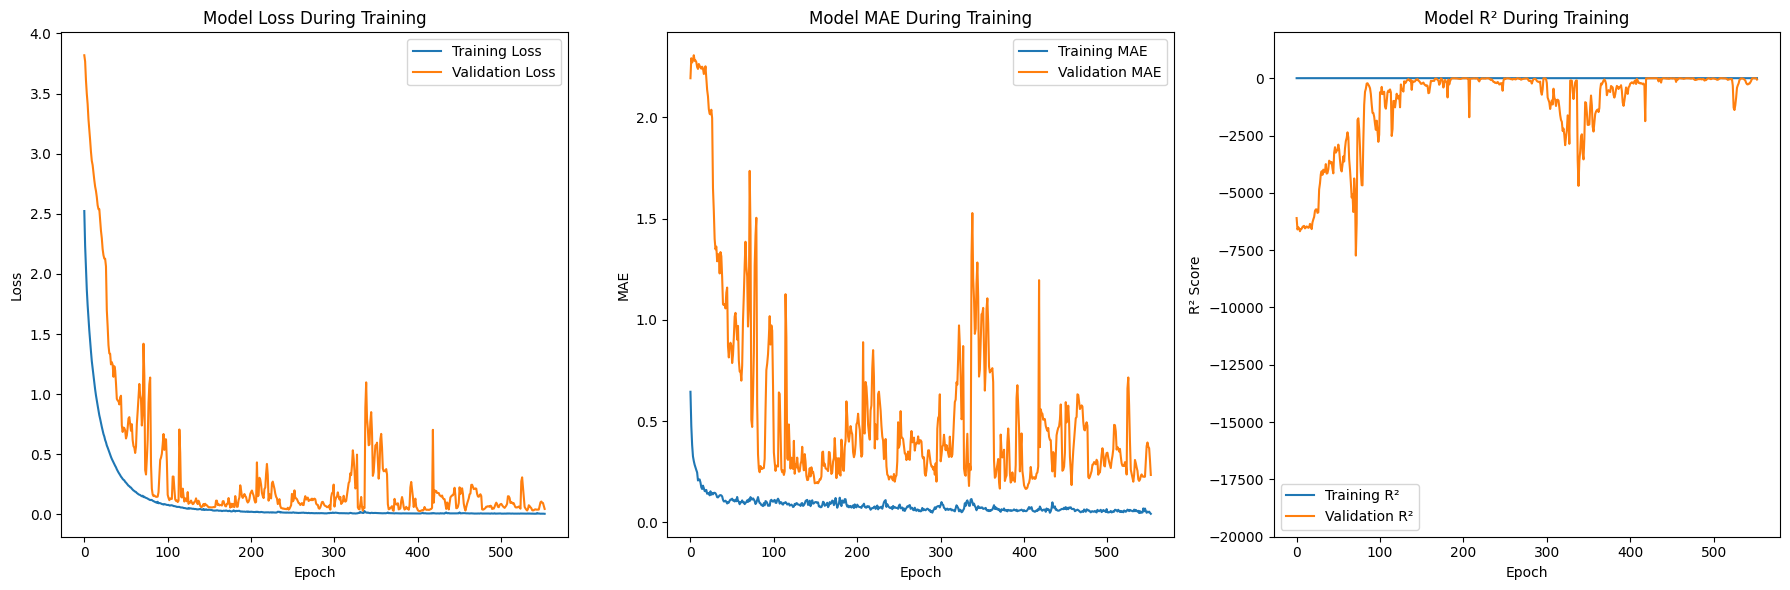

In [8]:
history_dict = history.history
print(history_dict.keys())

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loss
axs[0].plot(history_dict['loss'], label='Training Loss')
axs[0].plot(history_dict['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss During Training')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# MAE
axs[1].plot(history_dict['mae'], label='Training MAE')
axs[1].plot(history_dict['val_mae'], label='Validation MAE')
axs[1].set_title('Model MAE During Training')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# R² Score
axs[2].plot(history_dict['r2_scoree'], label='Training R²')
axs[2].plot(history_dict['val_r2_scoree'], label='Validation R²')
axs[2].set_title('Model R² During Training')
axs[2].set_ylabel('R² Score')
axs[2].set_xlabel('Epoch')
axs[2].set_ylim(-20000, 2000) 
axs[2].legend()

plt.tight_layout()
plt.show()

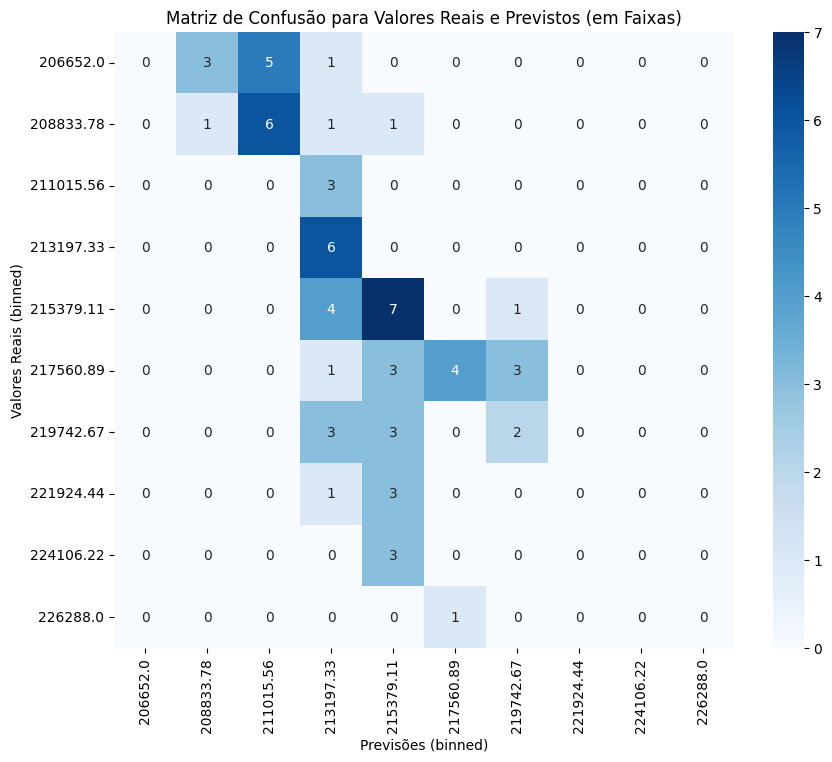

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

n_bins = 10

min_val = min(min(y_test), min(y_pred_test))
max_val = max(max(y_test), max(y_pred_test))

bins = np.linspace(min_val, max_val, n_bins)

y_test_binned = np.digitize(y_test, bins)
y_pred_binned = np.digitize(y_pred_test, bins)

conf_matrix = confusion_matrix(y_test_binned, y_pred_binned, labels=range(1, n_bins+1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=bins.round(2), yticklabels=bins.round(2))
plt.title('Matriz de Confusão para Valores Reais e Previstos (em Faixas)')
plt.xlabel('Previsões (binned)')
plt.ylabel('Valores Reais (binned)')
plt.show()

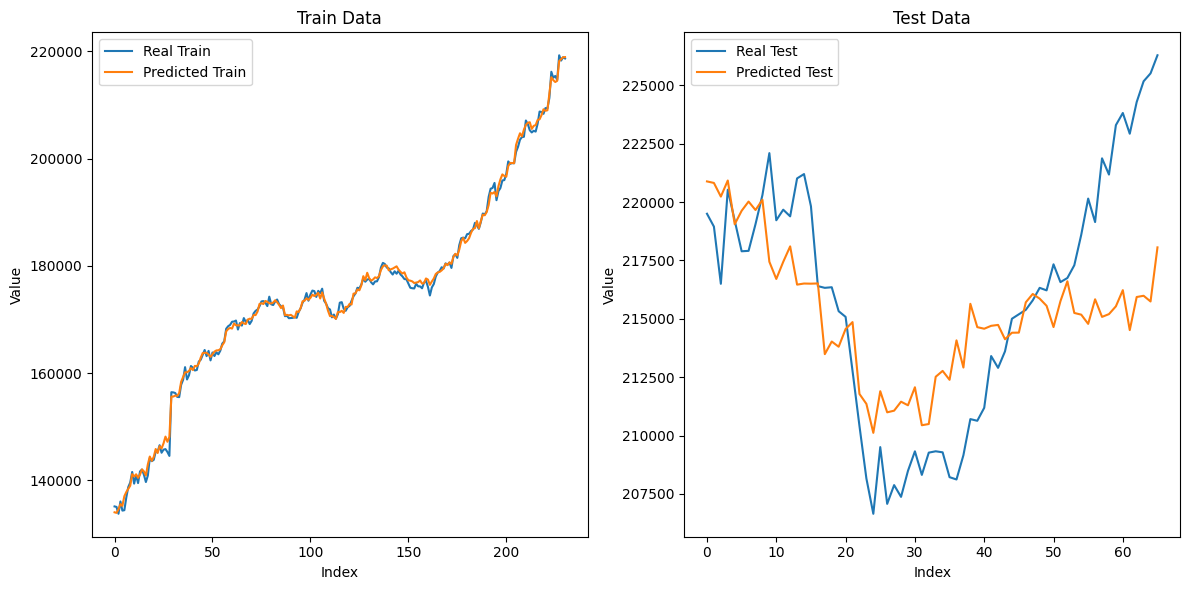

In [10]:
plt.figure(figsize=(12, 6))

# Plot para o conjunto de treino
plt.subplot(1, 2, 1)
plt.plot(y_train_real, label="Real Train")
plt.plot(y_pred_train, label="Predicted Train")
plt.title("Train Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

# Plot para o conjunto de teste
plt.subplot(1, 2, 2)
plt.plot(y_test_real, label="Real Test")
plt.plot(y_pred_test, label="Predicted Test")
plt.title("Test Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

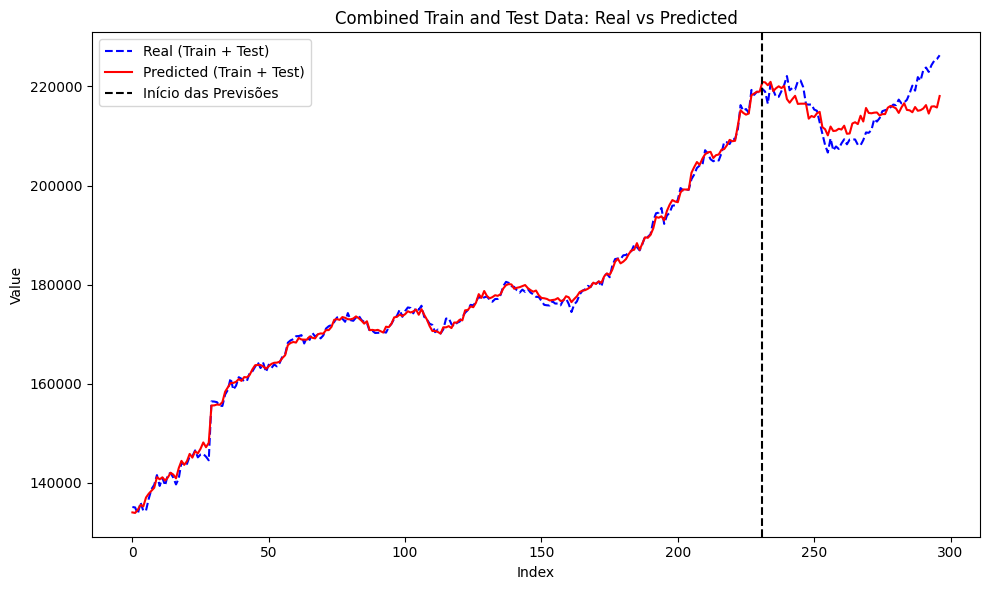

In [11]:
y_real_combined = np.concatenate([y_train_real, y_test_real])
y_pred_combined = np.concatenate([y_pred_train, y_pred_test])

plt.figure(figsize=(10, 6))

plt.plot(y_real_combined, label="Real (Train + Test)", linestyle='--', color='blue')
plt.plot(y_pred_combined, label="Predicted (Train + Test)", linestyle='-', color='red')

plt.axvline(x=len(y_train), color='black', linestyle='--', label='Início das Previsões')

# Configurações do gráfico
plt.title("Combined Train and Test Data: Real vs Predicted")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

#### Dados de validacao

In [12]:
X_valid_scaled = X_valid_scaled.reshape((X_valid_scaled.shape[0], 
                                         timesteps, 
                                         X_valid_scaled.shape[1]))

# Now, prediction will work without issues
y_valid_pred_scaled = model.predict(X_valid_scaled)
y_valid_pred = scaler_y.inverse_transform(y_valid_pred_scaled)
y_valid_real = scaler_y.inverse_transform(y_valid_scaled)

# Calculate metrics for validation data
mae_valid, r2_valid, mse_valid, acc_valid = calcular_metricas(y_valid_real, 
                                                              y_valid_pred, 
                                                              "Validação")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Validação: MAE: 10273.00, R²: -6.86, MSE: 114459940.60, Acurácia: 95.52%


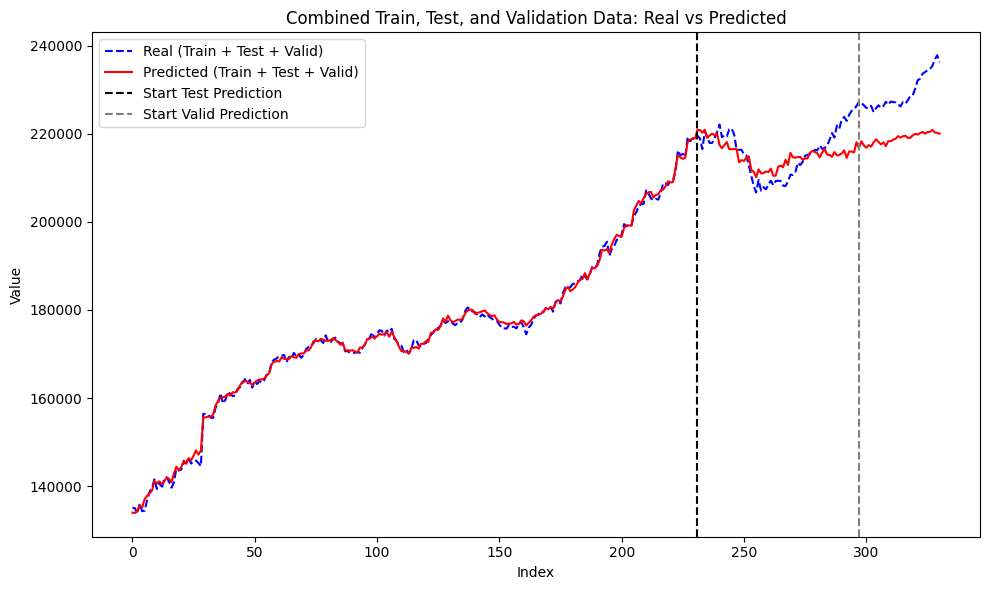

In [13]:
y_real_combined = np.concatenate([y_train_real, y_test_real, y_valid_real])
y_pred_combined = np.concatenate([y_pred_train, y_pred_test, y_valid_pred])

# Plotando os dados
plt.figure(figsize=(10, 6))

plt.plot(y_real_combined, label="Real (Train + Test + Valid)", linestyle='--', color='blue')
plt.plot(y_pred_combined, label="Predicted (Train + Test + Valid)", linestyle='-', color='red')

# Marcando o início da previsão de teste e validação
plt.axvline(x=len(y_train_real), color='black', linestyle='--', label='Start Test Prediction')
plt.axvline(x=len(y_train_real) + len(y_test_real), color='gray', linestyle='--', label='Start Valid Prediction')

# Configurações do gráfico
plt.title("Combined Train, Test, and Validation Data: Real vs Predicted")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

### Results

In [14]:
results = { 
    'Conjunto': ['Treino', 'Teste', 'Validação'],
    'MAE': [mae_train, mae_test, mae_valid],
    'R²': [r2_train, r2_test, r2_valid],
    'MSE': [mse_train, mse_test, mse_valid],
    'Acurácia (%)': [acuracia_train, acuracia_test, acc_valid]
}

results_df = pd.DataFrame(results)
results_df

,Conjunto,MAE,R²,MSE,Acurácia (%)
0,Treino,647.780574,0.998096,6.731538e+05,99.629348
1,Teste,3103.587595,0.446537,1.558852e+07,98.562319
2,Validação,10273.000000,-6.864072,1.144599e+08,95.517849


In [15]:
import os
import json

def salvar_resultados_modelo(modelo_nome, localizacao,resultados_df):
    # Criar estrutura para salvar
    results_dict = resultados_df.to_dict(orient='records')
    results_dict_with_model = {
        "Modelo": modelo_nome,
        "Localização": localizacao,
        "Resultados": results_dict
    }

    # Caminho do diretório e do arquivo JSON
    directory = "modelos"
    json_filename = os.path.join(directory, 'resultadosModelos.json')

    # Criar o diretório se não existir
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Verificar se o arquivo já existe
    if os.path.exists(json_filename):
        with open(json_filename, 'r') as json_file:
            existing_data = json.load(json_file)
    else:
        existing_data = []

    # Adicionar os novos resultados
    existing_data.append(results_dict_with_model)

    # Salvar de volta no arquivo JSON
    with open(json_filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)

    print(f"Dados salvos e adicionados ao arquivo {json_filename}")


salvar_resultados_modelo("LSTM", local, results_df)

Dados salvos e adicionados ao arquivo modelos\resultadosModelos.json
